# Setup
Loading all the necessary libraries.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import tabulate

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

import qda

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

from sklearn.decomposition import PCA

In [176]:
n_objects = 80

# Helper functions
Here we define the functions that we later use in the proceeding of the notebook.  
You can find here the `img_info_to_part_id` and `rotate_and_crop` functions cited in the report. 

In [36]:
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 1
	elif location == "top_right":
		return (imgid - 1) * 4 + 2
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 3
	else:
		raise ValueError("Invalid location: {}".format(location))

# example
print(img_info_to_part_id("img01.bmp", "top_left"))
print(img_info_to_part_id("img01.bmp", "bottom_left"))
print(img_info_to_part_id("img01.bmp", "top_right"))
print(img_info_to_part_id("img01.bmp", "bottom_right"))
print()
print(img_info_to_part_id("img02.bmp", "top_left"))
print(img_info_to_part_id("img02.bmp", "bottom_left"))
print(img_info_to_part_id("img02.bmp", "top_right"))
print(img_info_to_part_id("img02.bmp", "bottom_right"))

0
1
2
3

4
5
6
7


In [37]:
def part_id_to_img_info(part_id):
	pid_copy = part_id
	while pid_copy % 4 != 0:
		pid_copy -= 1
	imgnum = pid_copy // 4 +1 
	imgnum = "{:02d}".format(imgnum)

	if part_id % 4 == 0:
		location = "top_left"
	elif part_id % 4 == 1:
		location = "bottom_left"
	elif part_id % 4 == 2:
		location = "top_right"
	elif part_id % 4 == 3:
		location = "bottom_right"
	else:
		raise ValueError("Invalid part ID: {}".format(part_id))

	return imgnum, location

# example
print(part_id_to_img_info(0))
print(part_id_to_img_info(1))
print(part_id_to_img_info(2))
print(part_id_to_img_info(3))
print()
print(part_id_to_img_info(4))
print(part_id_to_img_info(5))
print(part_id_to_img_info(6))
print(part_id_to_img_info(7))

('01', 'top_left')
('01', 'bottom_left')
('01', 'top_right')
('01', 'bottom_right')

('02', 'top_left')
('02', 'bottom_left')
('02', 'top_right')
('02', 'bottom_right')


In [38]:
cartella_immagini = {
	'originals': './Processed dataset/df old/',
	'rot&crop': './Processed dataset/df new/',
	# other possible folders
}

# in english: generate_image_path
def genera_percorso_immagine(part_id, which_ones="originals",option="seg"):	
	imgnum, location = part_id_to_img_info(part_id)
	real_option = option
	if option=="seg":
		real_option = "segmented"
	else:
		real_option = "labeled"

	nome_immagine = f"img{imgnum}.bmp_{location}_{real_option}.png"
	return os.path.join(cartella_immagini[which_ones], nome_immagine)

# Utilizzo della funzione
print(genera_percorso_immagine(0, "originals"))
print(genera_percorso_immagine(1, "originals"))
print(genera_percorso_immagine(2, "originals"))
print(genera_percorso_immagine(3, "originals"))

./Processed dataset/df old/img01.bmp_top_left_segmented.png
./Processed dataset/df old/img01.bmp_bottom_left_segmented.png
./Processed dataset/df old/img01.bmp_top_right_segmented.png
./Processed dataset/df old/img01.bmp_bottom_right_segmented.png


In [39]:
def visualize_object(part_id):
	plt.figure(figsize=(8, 10))

	plt.subplot(1,2,1)
	img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","lab"))
	height, width = img_new.shape[:2]
	print("height, width:", height, width)
	zoom_factor = 0.8 
	zoomed_width = width * zoom_factor
	zoomed_height = height * zoom_factor
	x_center = width // 2
	y_center = height // 2
	x1 = max(0, x_center - zoomed_width // 2)
	x2 = min(width, x_center + zoomed_width // 2)
	y1 = max(0, y_center - zoomed_height // 2)
	y2 = min(height, y_center + zoomed_height // 2)
	plt.imshow(img_new, cmap="gray")
	plt.axis('off')
	plt.xlim(x1, x2)
	plt.ylim(y2, y1)
	plt.title(f"img new (part_id {part_id}, nvoids={df_new_parts.iloc[part_id]['Num_voids']})")

	plt.subplot(1, 2, 2)
	# plt.subplot(1, 4, 4)
	img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","seg"))
	print("height, width:", img_new.shape[:2])
	plt.imshow(img_new,cmap="gray")
	plt.title(f"img new (part_id {part_id}, nvoids={df_new_parts.iloc[part_id]['Num_voids']})")
	plt.axis("off")

	plt.tight_layout()
	plt.show()

In [40]:
def rotate_and_crop(img, rect, verbose=0):
	# get params
	center, size, angle = rect[0], rect[1], rect[2]
	
	if angle > 45:
		angle = angle - 90
	if verbose == 1:
		print(f"Angle inside function is {angle}")
	
	center, size = tuple(map(int, center)), tuple(map(int, size))
	if verbose==1:
		print(rect)
		print(center)
		print(size)
	# get row and col num in img
	height, width = img.shape[0], img.shape[1]
	# rotation matrix
	M = cv2.getRotationMatrix2D(center, angle, 1)
	# apply rotation
	img_rot = cv2.warpAffine(img, M, (width, height))
	# crop it
	img_crop = cv2.getRectSubPix(img_rot, size, center)

	return img_crop, img_rot

In [41]:
def calculate_curvature(points):
	# Calcola la differenza delle coordinate x e y tra i punti successivi e precedenti
	dx = np.gradient(points[:, 0])
	dy = np.gradient(points[:, 1])

	# Calcola la seconda differenza delle coordinate x e y
	d2x = np.gradient(dx)
	d2y = np.gradient(dy)

	# Calcola la curvatura utilizzando la formula di curvatura
	curvature = (d2x * dy - d2y * dx) / (dx**2 + dy**2)**1.5

	return curvature

In [42]:
def summary_assumptions(data_points,titolo="",plotto=0):
	if plotto==1:
		plt.figure(figsize=(12,4))
		plt.subplot(1, 3, 1)
		stats.probplot(data_points,plot=plt)
		plt.subplot(1, 3, 2)
		plt.hist(data_points)
		plt.subplot(1, 3, 3)
		plt.plot(data_points,'o-')
		plt.suptitle(f"{titolo}")
		plt.show()
	_, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({titolo}) Normality p-value = {shapiro_pvalue} - Normality at alpha 5%? {shapiro_pvalue>0.05}")
	_, pval_runs = runstest_1samp(data_points, correction=False)
	print(f'({titolo}) Runs test p-value = {pval_runs} - Random data at alpha 5%? {pval_runs>0.05}')

# Dataset manipulation

In [43]:
# call original python script
%run image_analysis_function.py

## df old

In [44]:
df_old = pd.read_csv('./Processed dataset/df old/image_statistics.csv')

# add 'Part_ID' using img_info_to_part_id
df_old['Part_ID'] = df_old.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# add 'Num_voids' using group by
df_old['Num_voids'] = df_old.groupby('Part_ID')['ID'].transform('max')

# parts and voids split
df_old_parts = df_old[df_old['Region type'] == 'part']
df_old_voids = df_old[df_old['Region type'] == 'void']
df_old_parts.reset_index(drop=True, inplace=True)
df_old_voids.reset_index(drop=True, inplace=True)

df_old.head(10)

Image name  Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp  top_left        part   0          39334            3979.892   
1  img01.bmp  top_left        void   1             94              37.556   
2  img01.bmp  top_left        void   2             95              46.142   
3  img01.bmp  top_left        void   3            239              77.527   
4  img01.bmp  top_left        void   4            195              61.420   
5  img01.bmp  top_left        void   5            146              54.770   
6  img01.bmp  top_left        void   6            192              71.835   
7  img01.bmp  top_left        void   7            322              72.770   
8  img01.bmp  top_left        void   8            342              76.184   
9  img01.bmp  top_left        void   9            292              78.912   

   Eccentricity  Orientation [radians]  Solidity  Extent  \
0         0.145                 -1.399     0.775   0.658   
1         0.773                  1.445     0.949   0.696   
2         0.935                 -1.466     0.872   0.565   
3         0.942                 -1.432     0.909   0.569   
4         0.885                  1.545     0.907   0.577   
5         0.883                  0.818     0.912   0.477   
6         0.954                 -1.440     0.881   0.529   
7         0.324                  0.429     0.947   0.610   
8         0.498                  0.893     0.927   0.594   
9         0.904                 -0.973     0.927   0.438   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0                     276.941                     274.023   
1                      14.463                       9.178   
2                      19.647                       6.959   
3                      31.984                      10.699   
4                      24.535                      11.419   
5                      20.885                       9.814   
6                      30.397                       9.124   
7                      22.009                      20.826   
8                      23.752                      20.593   
9                      31.198                      13.312   

   Equivalent Diameter [pixels]  Part_ID  Num_voids  
0                       223.789        0         41  
1                        10.940        0         41  
2                        10.998        0         41  
3                        17.444        0         41  
4                        15.757        0         41  
5                        13.634        0         41  
6                        15.635        0         41  
7                        20.248        0         41  
8                        20.867        0         41  
9                        19.282        0         41

## df_new

create it

In [45]:
output_folder = "./Processed dataset/df new/"
statistics = []

for part_id in range(0,n_objects):
	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# Applica il filtro bilaterale per ridurre il rumore
	blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
	# maybe blurred not really needed
	# decide it in the img input to the next function (choose gray or blurred_img)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)

	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)

		img_info = part_id_to_img_info(part_id)
		filename = f"img{img_info[0]}.bmp_{img_info[1]}_segmented.png"
		cv2.imwrite(os.path.join(output_folder, filename), cropped_image) 

		# print(type(cropped_image))
		# plt.figure(figsize=(12, 12))
		# plt.subplot(1,3,1)
		# plt.imshow(cropped_image)
		# plt.axis('off')
		# plt.title("cropped_image")

		# img_pil = Image.fromarray(cropped_image, 'RGB')
		# img_pil = img_pil.convert('L')
		# print(type(img_pil))
		# plt.imshow(img_pil,cmap="gray")
		# plt.axis('off')
		# plt.show()

		# gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
		# (T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
		# labeled_segmented_image = label(threshInv)
	
		image = Image.open(os.path.join(output_folder, filename))
		# Convert the image to grayscale
		image = image.convert('L')
		# # Increase the contrast
		enhancer = ImageEnhance.Contrast(image)
		image = enhancer.enhance(100)
		# width, height = image.size
		# image = image.crop((0,0,width,height))
		image = np.array(image)
		# plt.imshow(image, cmap='gray')
		# plt.axis('off')  # Nasconde gli assi
		# plt.show()
		otsu_thresh = threshold_otsu(image)
		image = image > otsu_thresh

		# Convert the boolean image to an 8-bit unsigned integer image
		# img = (threshInv.astype(np.uint8) * 255)
		img = (image.astype(np.uint8) * 255)
		# Use regionprops to get properties of the region
		part_props = regionprops(img)[0]  # Get the first (and only) region
		# Crop the image with margin around the bounding box
		minr, minc, maxr, maxc = part_props.bbox
		# print(part_props.bbox)
		minr_crop = max(minr + 12, 0)
		minc_crop = max(minc + 12, 0)
		maxr_crop = min(maxr - 12, img.shape[0])
		maxc_crop = min(maxc - 12, img.shape[1])
		padded_img = img[minr_crop:maxr_crop, minc_crop:maxc_crop]
		
		# Invert the padded image
		inv_padded_img = 255 - padded_img
		# plt.subplot(1,3,2)
		# plt.imshow(inv_padded_img,cmap="gray")
		# plt.axis('off')
		# plt.title("inv_padded_img")

		# Apply labeling
		labels = label(inv_padded_img, background=0)
		# props_voids = regionprops(labels)
		# Find the biggest region
		# biggest_region = max(props_voids, key=lambda region: region.area)
		# Set the pixels in the biggest region to 0
		# labels[labels == biggest_region.label] = 0
		# Repeat labeling
		# labels = label(labels, background=0)
		props_voids = regionprops(labels)
		# Create a figure and axes
		plt.figure(figsize=(8, 8))
		fig, ax = plt.subplots()
		# Display the image
		ax.imshow(labels, cmap='nipy_spectral')
		# Annotate label numbers

		for region in regionprops(labels):
			# Get the coordinates of the centroid
			y, x = region.centroid
			# Annotate the label number at the centroid
			ax.text(x, y, str(region.label), color='white')
		# Save the labeled image  		
		labeled_filename = f"img{img_info[0]}.bmp_{img_info[1]}_labeled.png"
		labeled_output_path = os.path.join(output_folder, labeled_filename)
		plt.savefig(labeled_output_path)
		# Close the figure to free up memory
		# plt.show()
		# plt.close()
		plt.close('all')


		# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
		statistics.append({
			"Image name": f"img{img_info[0]}.bmp",
			"Position": img_info[1],
			"Region type": "part",
			"ID": 0,
			"Area [pixels]": round(part_props.area, 3),
			"Perimeter [pixels]": round(part_props.perimeter, 3),
			"Eccentricity": round(part_props.eccentricity, 3),
			"Orientation [radians]": round(part_props.orientation, 3),
			"Solidity": round(part_props.solidity, 3),
			"Extent": round(part_props.extent, 3),
			"Major Axis Length [pixels]": round(part_props.major_axis_length, 3),
			"Minor Axis Length [pixels]": round(part_props.minor_axis_length, 3),
			"Equivalent Diameter [pixels]": round(part_props.equivalent_diameter, 3),
			"Part_ID": part_id,
			"Num_voids": len(props_voids)
		})

		old_size = len(statistics)
		# print(f"Old size: {len(statistics)}")

		# Loop over each void
		for i, prop in enumerate(props_voids, start=1):
			# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
			statistics.append({
				"Image name": f"img{img_info[0]}.bmp",
				"Position": img_info[1],
				"Region type": "void",
				"ID": i,
				"Area [pixels]": round(prop.area, 3),
				"Perimeter [pixels]": round(prop.perimeter, 3),
				"Eccentricity": round(prop.eccentricity, 3),
				"Orientation [radians]": round(prop.orientation, 3),
				"Solidity": round(prop.solidity, 3),
				"Extent": round(prop.extent, 3),
				"Major Axis Length [pixels]": round(prop.major_axis_length, 3),
				"Minor Axis Length [pixels]": round(prop.minor_axis_length, 3),
				"Equivalent Diameter [pixels]": round(prop.equivalent_diameter, 3),
				"Part_ID": part_id,
				"Num_voids": len(props_voids)
			})

		# print(f"Nvoids from props: {len(props_voids)}")
		# print(f"Rows added now: {len(statistics)-old_size}")
		# print(f"Nvoids in df old were: {df_old_parts.iloc[part_id]['Num_voids']}\n")
		if (len(statistics)-old_size) != len(props_voids):
			print("Something strange happened")
			break

# Convert the list of dictionaries to a DataFrame
statistics_df = pd.DataFrame(statistics)
# Export the DataFrame to a CSV file in the output_folder
output_file = os.path.join(output_folder, "image_statistics.csv")
statistics_df.to_csv(output_file, index=False)

read it 

In [179]:
df_new = pd.read_csv('./Processed dataset/df new/image_statistics.csv')

# add 'Part_ID' using img_info_to_part_id
df_new['Part_ID'] = df_new.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# add 'Num_voids' using group by
df_new['Num_voids'] = df_new.groupby('Part_ID')['ID'].transform('max')

# parts and voids split
df_new_parts = df_new[df_new['Region type'] == 'part']
df_new_voids = df_new[df_new['Region type'] == 'void']
df_new_parts.reset_index(drop=True, inplace=True)
df_new_voids.reset_index(drop=True, inplace=True)

print(df_new_parts.shape)
df_new.head(10)

(80, 15)


Image name  Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp  top_left        part   0          38291            4105.674   
1  img01.bmp  top_left        void   1            104              40.142   
2  img01.bmp  top_left        void   2            106              47.799   
3  img01.bmp  top_left        void   3            263              80.355   
4  img01.bmp  top_left        void   4            211              64.006   
5  img01.bmp  top_left        void   5            159              56.355   
6  img01.bmp  top_left        void   6            211              73.077   
7  img01.bmp  top_left        void   7            339              75.841   
8  img01.bmp  top_left        void   8            361              78.184   
9  img01.bmp  top_left        void   9            329              77.770   

   Eccentricity  Orientation [radians]  Solidity  Extent  \
0         0.153                 -1.268     0.760   0.743   
1         0.752                 -1.556     0.912   0.693   
2         0.935                 -1.335     0.898   0.589   
3         0.939                 -1.307     0.895   0.501   
4         0.884                 -1.478     0.887   0.601   
5         0.874                  0.932     0.888   0.523   
6         0.951                 -1.313     0.847   0.471   
7         0.326                  0.692     0.929   0.589   
8         0.502                  1.001     0.928   0.602   
9         0.718                  0.249     0.901   0.580   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0                     277.925                     274.667   
1                      14.874                       9.809   
2                      20.548                       7.293   
3                      32.887                      11.318   
4                      25.354                      11.839   
5                      21.442                      10.408   
6                      31.267                       9.708   
7                      22.505                      21.278   
8                      24.343                      21.051   
9                      26.044                      18.126   

   Equivalent Diameter [pixels]  Part_ID  Num_voids  
0                       220.802        0         41  
1                        11.507        0         41  
2                        11.617        0         41  
3                        18.299        0         41  
4                        16.391        0         41  
5                        14.228        0         41  
6                        16.391        0         41  
7                        20.776        0         41  
8                        21.439        0         41  
9                        20.467        0         41

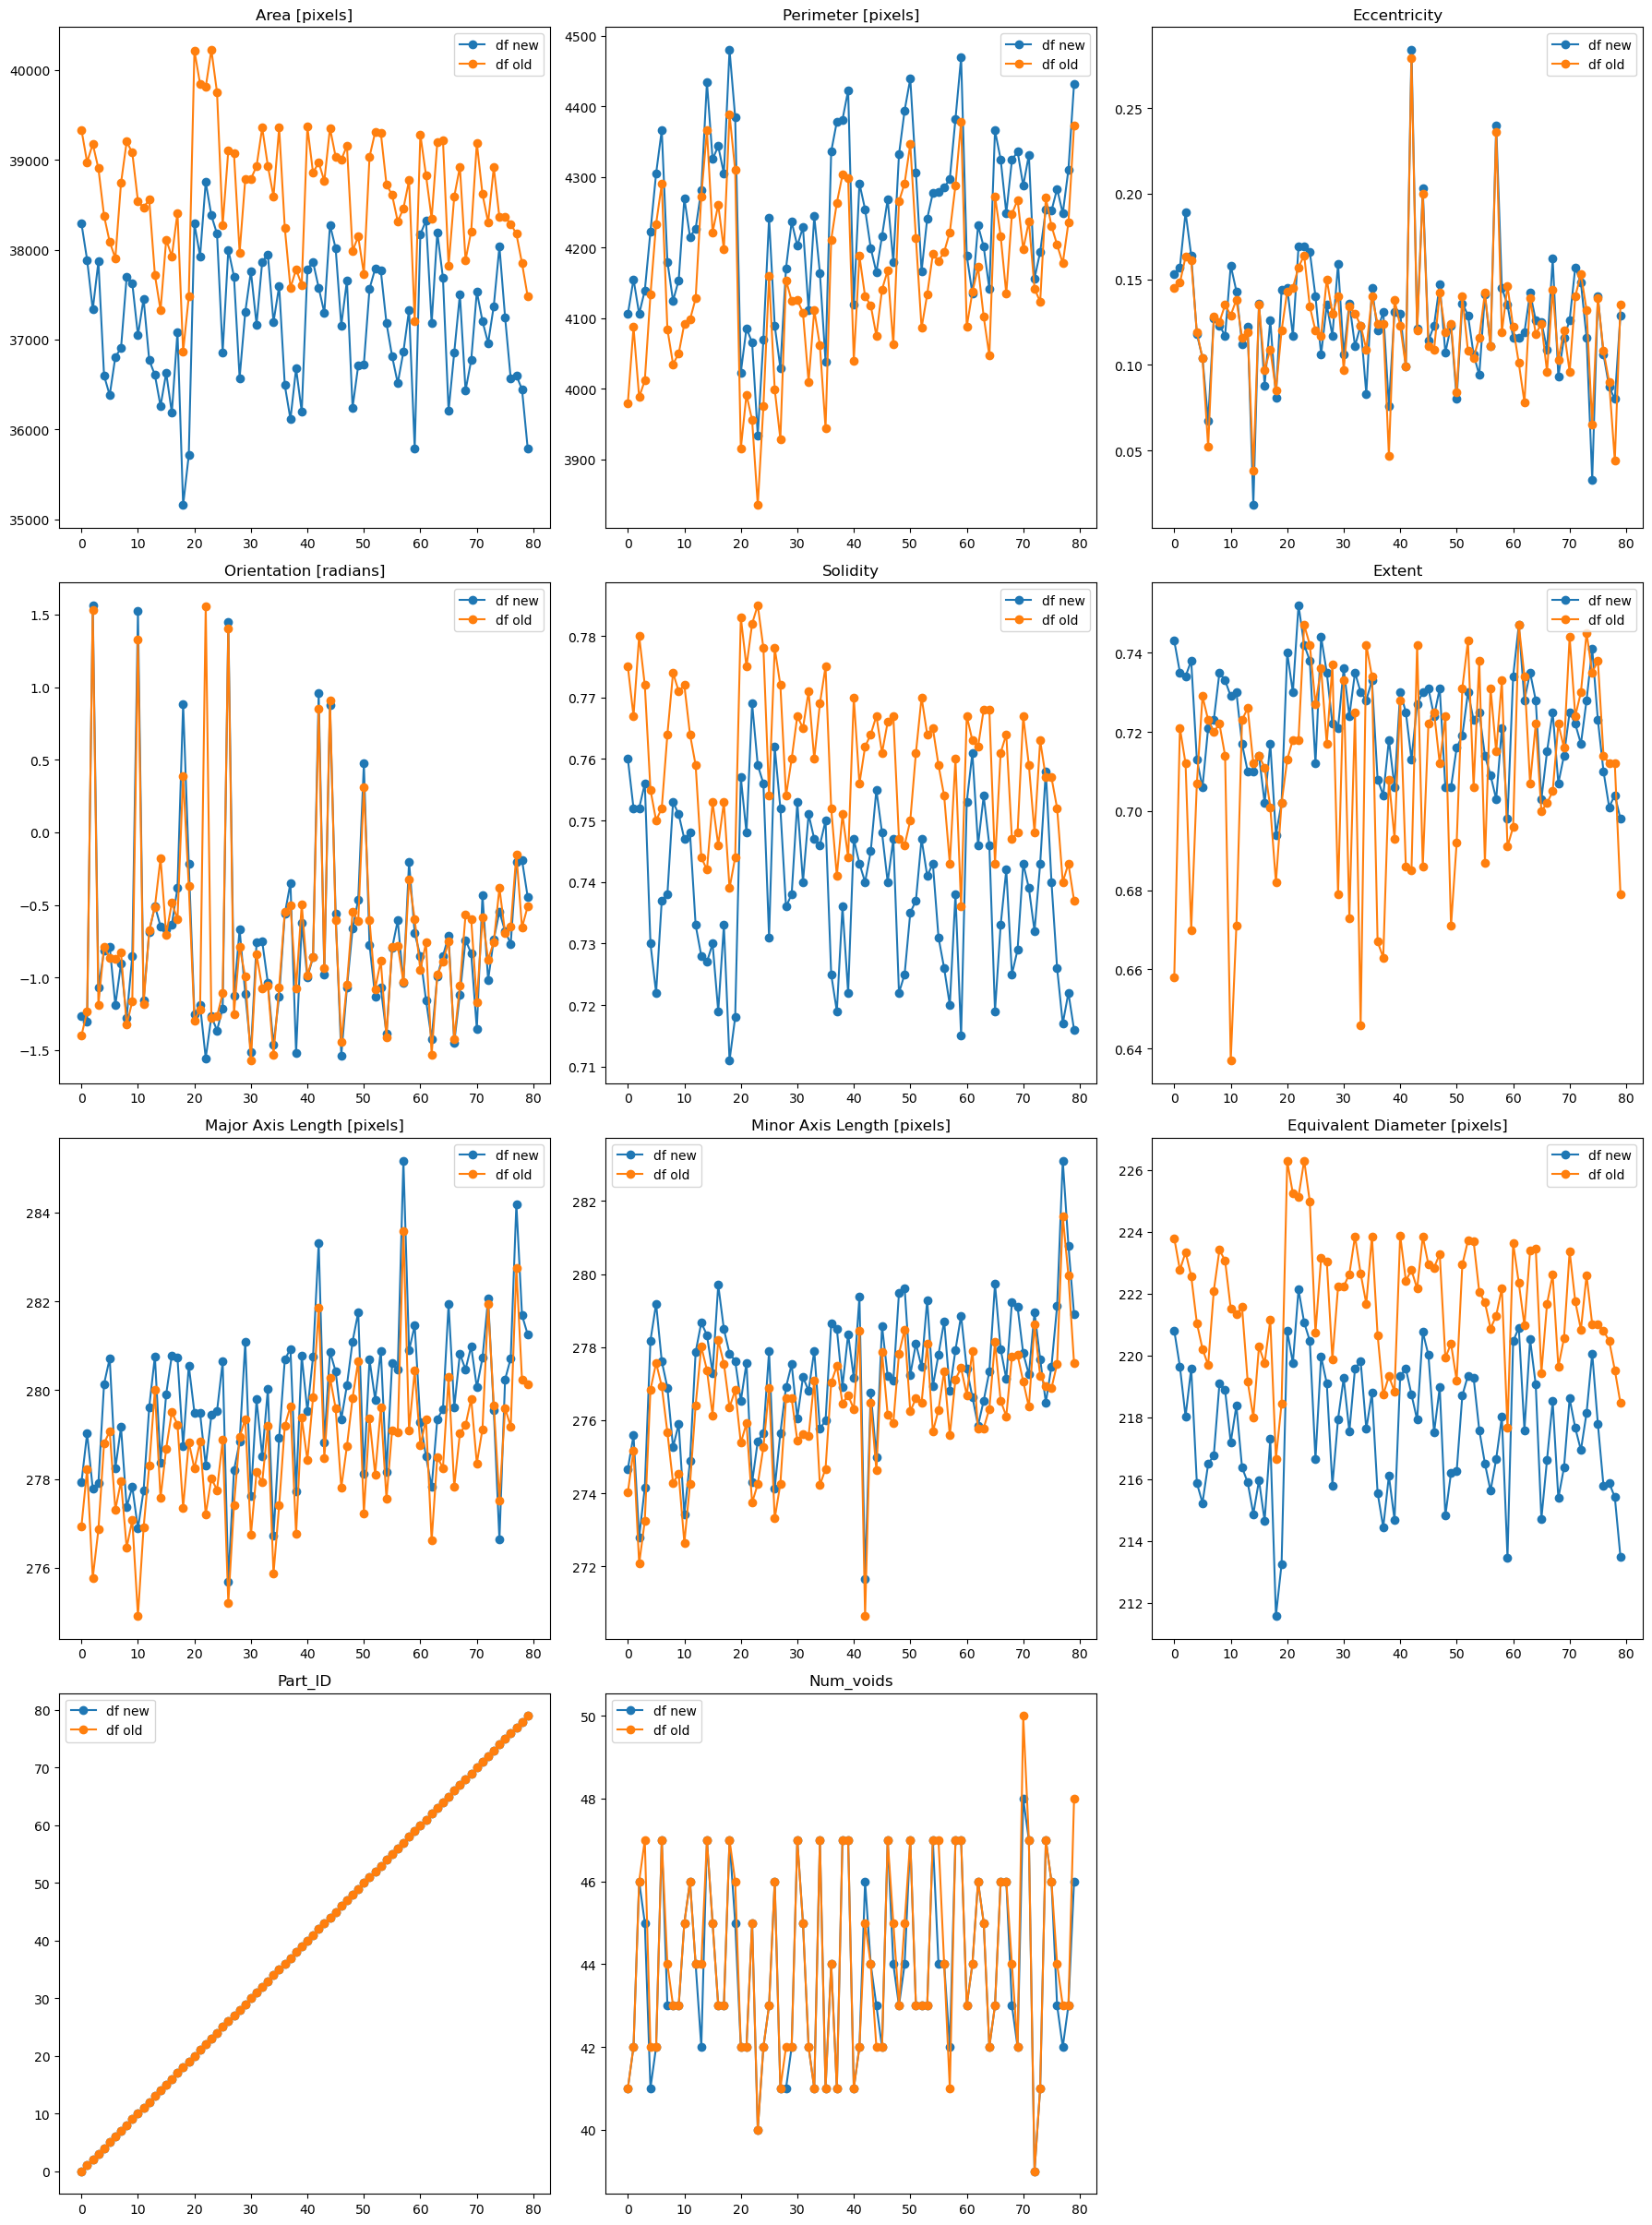

In [47]:
# comparing
meaningful_cols = len(df_new_parts.columns[4:])
num_rows = meaningful_cols // 3 + meaningful_cols % 3  # Calcola il numero di righe necessarie per i subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))  # Crea i subplot

for i, column in enumerate(df_new_parts.columns[4:]):
	row_index = i // 3
	col_index = i % 3

	axes[row_index, col_index].plot(df_new_parts[column],'o-', label='df new')
	axes[row_index, col_index].plot(df_old_parts[column],'o-', label='df old')

	axes[row_index, col_index].set_title(column)
	axes[row_index, col_index].legend()

fig.delaxes(axes[num_rows - 1, meaningful_cols % 3])
fig.delaxes(axes[num_rows - 2, meaningful_cols % 3])
fig.delaxes(axes[num_rows - 1, meaningful_cols % 3-1])
fig.delaxes(axes[num_rows - 1, meaningful_cols % 3-2])
plt.tight_layout()
plt.show()

# Datasets comparison
Through Nonparametric tests.

In [129]:
B = int(1e3)
results = []
start_index = 4
end_index = len(df_old_parts.columns) 

for col in df_old_parts.columns[start_index:end_index]:
    dataset1 = df_new_parts.loc[:, col].values # STAI RIMUOVENDO DATI 
    dataset2 = df_old_parts.loc[:, col].values

    dimD1 = dataset1.shape[0]
    dimD2 = dataset2.shape[0]
    min_dim = min(dimD1, dimD2)
    dataset1 = dataset1[:min_dim]
    dataset2 = dataset2[:min_dim]
    dataset = dataset1 - dataset2

    mu_hat = np.mean(dataset)
    sigma_hat = np.std(dataset)

    np.random.seed(42)
    t_boot = np.zeros(B)
    for b in range(B):
        x_boot = np.random.choice(dataset, replace=True, size=len(dataset))
        mu_boot = np.mean(x_boot)
        sigma_boot = np.std(x_boot)
    
        t_boot[b] = (mu_boot - mu_hat) / sigma_boot

    ALPHA = 0.05
    q_low = np.percentile(t_boot, ALPHA/2 * 100)
    q_up = np.percentile(t_boot, (1 - ALPHA/2) * 100)
    CI = {
        'Lower CI': mu_hat - q_up * sigma_hat,
        'Point Estimate': mu_hat,
        'Upper CI': mu_hat - q_low * sigma_hat
    }

    if (CI['Upper CI'] * CI['Lower CI'] > 0 ): # 0 not included 
        print(f"ATTENZIONE: L'intervallo di confidenza per la colonna {col} non contiene zero!")

    results.append([f"{col}", CI['Lower CI'], CI['Point Estimate'], CI['Upper CI']])

print(tabulate(results, headers=['Column', 'Lower CI', 'Point Estimate', 'Upper CI'], tablefmt='grid'))


ATTENZIONE: L'intervallo di confidenza per la colonna Area [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Perimeter [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Solidity non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Extent non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Major Axis Length [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Minor Axis Length [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Equivalent Diameter [pixels] non contiene zero!
ATTENZIONE: L'intervallo di confidenza per la colonna Num_voids non contiene zero!
+------------------------------+----------------+------------------+----------------+
| Column                       |       Lower CI |   Point Estimate |       Upper CI |
+==============================+================+==================+================+
| Area [pixels] 

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


In [130]:
B = int(1e3)
results = []
start_index = 4
end_index = len(df_old_voids.columns) 
diff = np.zeros(39)

# Definisci il range di immagini da 0 a 39
for img in range(40):

    # Itera sulle colonne del dataframe
    for col in df_old_voids.columns[start_index:end_index]:
        dataset1 = df_new_voids.loc[df_new_voids['Part_ID'] == img, col].values  # In teoria importa l'ordine perchè dovrei confrontare buco per buco, posso usare comunque t-boostrap? 
                                                                               # Io direi di sì ( test sulla media!! ) + STAI RIMUOVENDO DATI
        dataset2 = df_old_voids.loc[df_old_voids['Part_ID'] == img, col].values
        dimD1 = dataset1.shape[0]  # Assume che il numero di righe sia la dimensione rilevante
        dimD2 = dataset2.shape[0]
        min_dim = min(dimD1, dimD2)
        dataset1 = dataset1[:min_dim]
        dataset2 = dataset2[:min_dim]
        dataset = dataset1 - dataset2

        mu_hat = np.mean(dataset)
        sigma_hat = np.std(dataset)

        np.random.seed(42)
        t_boot = np.zeros(B)
        
        # Esegui il bootstrap
        for b in range(B):
            x_boot = np.random.choice(dataset, replace=True, size=len(dataset))
            mu_boot = np.mean(x_boot)
            sigma_boot = np.std(x_boot)
    
            t_boot[b] = (mu_boot - mu_hat) / sigma_boot

        ALPHA = 0.05
        q_low = np.percentile(t_boot, ALPHA/2 * 100)
        q_up = np.percentile(t_boot, (1 - ALPHA/2) * 100)
        CI = {
            'Lower CI': mu_hat - q_up * sigma_hat,
            'Point Estimate': mu_hat,
            'Upper CI': mu_hat - q_low * sigma_hat
        }

        if (CI['Upper CI'] * CI['Lower CI'] > 0 ): # 0 not included 
            print(f"ATTENZIONE: L'intervallo di confidenza per la colonna {col} non contiene zero!")
            diff[img] = 1 

        results.append([f"{col}\n(Part_ID = {img})", CI['Lower CI'], CI['Point Estimate'], CI['Upper CI']])

    print(tabulate(results, headers=['Column', 'Lower CI', 'Point Estimate', 'Upper CI'], tablefmt='grid'))


ATTENZIONE: L'intervallo di confidenza per la colonna Solidity non contiene zero!


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


+------------------------------+-------------+------------------+--------------+
| Column                       |    Lower CI |   Point Estimate |     Upper CI |
+==============================+=============+==================+==============+
| Area [pixels]                | -27.3227    |      18.8049     |  63.3162     |
| (Part_ID = 0)                |             |                  |              |
+------------------------------+-------------+------------------+--------------+
| Perimeter [pixels]           |  -3.93578   |       3.15383    |   9.72439    |
| (Part_ID = 0)                |             |                  |              |
+------------------------------+-------------+------------------+--------------+
| Eccentricity                 |  -0.0363188 |      -0.00497561 |   0.0276549  |
| (Part_ID = 0)                |             |                  |              |
+------------------------------+-------------+------------------+--------------+
| Orientation [radians]     

Boostrap t-intervals and standard CI for df_parts_new

In [131]:
# Boostrap 
B = int(1e3)
results = []
start_index = 4
end_index = len(df_new_parts.columns) 

for col in df_new_parts.columns[start_index:end_index]:
    dataset = df_new_parts.loc[:, col].values

    mu_hat = np.mean(dataset)
    sigma_hat = np.std(dataset)

    np.random.seed(42)
    t_boot = np.zeros(B)
    for b in range(B):
        x_boot = np.random.choice(dataset, replace=True, size=len(dataset))
        mu_boot = np.mean(x_boot)
        sigma_boot = np.std(x_boot)
    
        t_boot[b] = (mu_boot - mu_hat) / sigma_boot

    ALPHA = 0.05
    q_low = np.percentile(t_boot, ALPHA/2 * 100)
    q_up = np.percentile(t_boot, (1 - ALPHA/2) * 100)
    CI = {
        'Lower CI': mu_hat - q_up * sigma_hat,
        'Point Estimate': mu_hat,
        'Upper CI': mu_hat - q_low * sigma_hat
    }

    results.append([f"{col}", CI['Lower CI'], CI['Point Estimate'], CI['Upper CI']])

print(tabulate(results, headers=['Column', 'Lower CI', 'Point Estimate', 'Upper CI'], tablefmt='grid'))
## AREA AND Num_Wpixels ARE THE SAME THING 


+------------------------------+--------------+------------------+--------------+
| Column                       |     Lower CI |   Point Estimate |     Upper CI |
+==============================+==============+==================+==============+
| Area [pixels]                | 36921.3      |      37182.1     | 37434.7      |
+------------------------------+--------------+------------------+--------------+
| Perimeter [pixels]           |  4174.05     |       4214.57    |  4254.74     |
+------------------------------+--------------+------------------+--------------+
| Eccentricity                 |     0.115212 |          0.1258  |     0.135312 |
+------------------------------+--------------+------------------+--------------+
| Orientation [radians]        |    -0.939147 |         -0.73485 |    -0.344891 |
+------------------------------+--------------+------------------+--------------+
| Solidity                     |     0.736739 |          0.74105 |     0.745641 |
+---------------

Bonferroni CI

In [137]:
# Since Area, Perimeter, Eccentricity, Solidity, Extent, Major Axis Length,  Minor Axis Length, Equivalent Diameter, Num_Wpixels, Num_Bpixels, Wpixels_ratio are normal we can built the t-di-student CI
# We want an significant level of 0.05 in total, so we can built the Bonferroni CI

## AREA AND Num_Wpixels ARE THE SAME THING -> I CONSIDER ONLY THE AREA
 
from scipy.stats import f
from scipy.stats import t

data_parts_normal  = np.column_stack((
    df_new_parts['Area [pixels]'],
    df_new_parts['Perimeter [pixels]'],
    df_new_parts['Eccentricity'],
    df_new_parts['Solidity'],
    df_new_parts['Extent'],
    df_new_parts['Major Axis Length [pixels]'],
    df_new_parts['Minor Axis Length [pixels]'],
    df_new_parts['Equivalent Diameter [pixels]'],
    # df_new_parts['Num_Bpixels'], # new variables we added but in the end removed
    #df_new_parts['Num_Wpixels'], # new variables we added but in the end removed
    # df_new_parts['Wpixels_ratio'] # new variables we added but in the end removed
))

## AREA AND Num_Wpixels ARE THE SAME THING

column_names = [
    'Area',
    'Perimeter',
    'Eccentricity',
    'Solidity',
    'Extent',
    'Major Axis Length',
    'Minor Axis Length',
    'Equivalent Diameter',
    # 'Num_Bpixels', # new variables we added but in the end removed
    #'Num_Wpixels', # new variables we added but in the end removed
    # 'Wpixels_ratio' # new variables we added but in the end removed
]

# Creating DataFrame
df_parts_normal = pd.DataFrame(data_parts_normal, columns=column_names)

# Assuming 'dataset' is your DataFrame
# Dimensions
n = df_parts_normal.shape[0]
p = df_parts_normal.shape[1]
alpha = 0.05  # At level 5%

# Sample mean, covariance
x_mean = np.mean(df_parts_normal, axis = 0)
x_cov = np.cov(df_parts_normal, rowvar=False)
x_invcov = np.linalg.inv(x_cov)
cfr_fisher = ((n - 1) * p / (n - p)) * f.ppf(1 - alpha, p, n - p)

mu0 = np.array([0] * p)

# Bonferroni (for the difference) confidence intervals
k = p  # number of intervals I want to compute (set in advance)

cfr_t = t.ppf(1 - alpha / (2 * k), n - 1)
Bf = np.column_stack((
    x_mean - mu0 - cfr_t * np.sqrt(np.diag(x_cov) / n),
    x_mean - mu0,
    x_mean - mu0 + cfr_t * np.sqrt(np.diag(x_cov) / n)
))
Bf

### NB non cambiano così tanto...

array([[3.68134101e+04, 3.71821250e+04, 3.75508399e+04],
       [4.15526917e+03, 4.21457357e+03, 4.27387798e+03],
       [1.10904334e-01, 1.25800000e-01, 1.40695666e-01],
       [7.34488184e-01, 7.41050000e-01, 7.47611816e-01],
       [7.17701990e-01, 7.24100000e-01, 7.30498010e-01],
       [2.78441335e+02, 2.79064350e+02, 2.79687365e+02],
       [2.75939556e+02, 2.76700800e+02, 2.77462044e+02],
       [2.16488601e+02, 2.17569000e+02, 2.18649399e+02]])

In [138]:
## boostrap t intervals for df_new_voids after computing the mean for each image

B = int(1e3)
results = []

start_index = 4

end_index = len(df_new_voids.columns) 

diff = np.zeros(39)
avgdataset = np.empty((0, df_new_voids.columns[start_index:end_index].shape[0]))  # num_columns should be the number of columns in your dataset


# Definisci il range di immagini da 0 a 39
for img in range(40):

    dataset = df_new_voids.loc[df_new_voids['Part_ID'] == img, df_new_voids.columns[start_index:end_index]].values      
    avg = np.mean(dataset, axis = 0)
    avgdataset = np.vstack((avgdataset, avg))


column_names = df_new_voids.columns[start_index:end_index].tolist()

avgdataset = pd.DataFrame(avgdataset, columns= column_names)


# Itera sulle colonne del dataframe
for col in df_new_voids.columns[start_index:end_index]:
    dataset = avgdataset.loc[:,col].values  

    mu_hat = np.mean(dataset)
    sigma_hat = np.std(dataset)

    np.random.seed(42)
    t_boot = np.zeros(B)
        
     # Esegui il bootstrap
    for b in range(B):
        x_boot = np.random.choice(dataset, replace=True, size=len(dataset))
        mu_boot = np.mean(x_boot)
        sigma_boot = np.std(x_boot)
    
        t_boot[b] = (mu_boot - mu_hat) / sigma_boot

    ALPHA = 0.05
    q_low = np.percentile(t_boot, ALPHA/2 * 100)
    q_up = np.percentile(t_boot, (1 - ALPHA/2) * 100)
    CI = {
        'Lower CI': mu_hat - q_up * sigma_hat,
        'Point Estimate': mu_hat,
        'Upper CI': mu_hat - q_low * sigma_hat
        }

    results.append([f"{col}", CI['Lower CI'], CI['Point Estimate'], CI['Upper CI']])

print(tabulate(results, headers=['Column', 'Lower CI', 'Point Estimate', 'Upper CI'], tablefmt='grid'))


+------------------------------+------------+------------------+------------+
| Column                       |   Lower CI |   Point Estimate |   Upper CI |
+==============================+============+==================+============+
| Area [pixels]                | 285.843    |       292.449    | 298.816    |
+------------------------------+------------+------------------+------------+
| Perimeter [pixels]           |  69.56     |        70.696    |  71.8184   |
+------------------------------+------------+------------------+------------+
| Eccentricity                 |   0.81815  |         0.824125 |   0.829432 |
+------------------------------+------------+------------------+------------+
| Orientation [radians]        |   0.108643 |         0.128994 |   0.15297  |
+------------------------------+------------+------------------+------------+
| Solidity                     |   0.913952 |         0.91691  |   0.919453 |
+------------------------------+------------+------------------+

# New variables

## adding curvature

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


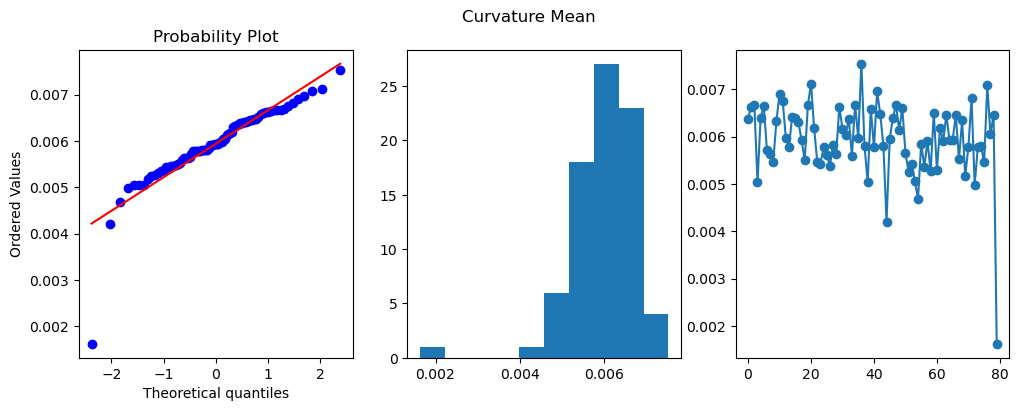

(Curvature Mean) Normality p-value = 2.01355007334314e-07 - Normality at alpha 5%? False
(Curvature Mean) Runs test p-value = 0.11627149959025725 - Random data at alpha 5%? True


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [180]:
curvatures_mean = np.zeros(n_objects)

for part_id in range(n_objects):

	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
	# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)
	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	img_with_contours = img.copy()

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		# print(f"Angle here is {rect[2]}")
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)
		# print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
		# cropped_images.append(cropped_image)                
		# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

		edged = cv2.Canny(rot_image, 30, 200)
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) 
		# maybe better
		contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE )
		# used officially
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )
		largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# reconnect end with begin points
	contours_points = np.append(largest_contours[0][:, 0], [largest_contours[0][:, 0][0]], axis=0)

	x_coords = [point[0] for point in contours_points]
	y_coords = [point[1] for point in contours_points]
	curvature = pd.Series(calculate_curvature(contours_points)).dropna()
	curvature = np.array(curvature)
	# curvature = curvature**1/3

	# curvatures_mean[part_id] = np.max(np.abs(curvature))+np.mean(curvature)
	
	curvatures_mean[part_id] = np.mean((curvature))
	# curvatures_mean[part_id] = np.max(curvature)

summary_assumptions(curvatures_mean,"Curvature Mean",plotto=1)
# summary assumption now fails but makes sense, we are on the complete dataset now, 
# not in phase 1
df_new_parts["Curvature Mean"] = curvatures_mean

## adding max void perimeter

In [181]:
biggest_void_perimeter = np.zeros(n_objects)
for pid in range(0,n_objects):
	img_df = df_new_voids.loc[df_new_voids['Part_ID'] == pid]
	biggest_void_perimeter[pid] = np.max(img_df["Perimeter [pixels]"])
	# print(f'biggest void for {pid} was at index {np.argmax(img_df["Area [pixels]"])+1}')

df_new_parts["Max Void Perimeter"] = biggest_void_perimeter

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## adding max void area

In [182]:
biggest_void_areas = np.zeros(n_objects)
for pid in range(0,n_objects):
	img_df = df_new_voids.loc[df_new_voids['Part_ID'] == pid]
	biggest_void_areas[pid] = np.max(img_df["Area [pixels]"])
	# print(f'biggest void for {pid} was at index {np.argmax(img_df["Area [pixels]"])+1}')

df_new_parts["Max Void Area"] = biggest_void_areas

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## adding white pixels ratio

In [16]:
def count_pixels(pid):
	# same code of the df_new generation procedure
	image_path = genera_percorso_immagine(pid, "rot&crop")
	image = Image.open(image_path)
	image = image.convert('L')
	enhancer = ImageEnhance.Contrast(image)
	image = enhancer.enhance(100)
	image = np.array(image)
	otsu_thresh = threshold_otsu(image)
	image = image > otsu_thresh

	shape = np.shape(image)
	num_white_pixels = np.sum(image)
	num_black_pixels = (image == 0).sum()

	assert num_white_pixels + num_black_pixels == shape[0] * shape[1]
	return num_white_pixels, num_black_pixels

def pixels_ratio(pid):
	# we return #white pixels / #tot image pixels
	white_pixels = count_pixels(pid)[0]
	image_path = genera_percorso_immagine(pid, "rot&crop")
	image = Image.open(image_path)
	shape = np.shape(image)
	tot_pixels = shape[0]*shape[1]
	return white_pixels/tot_pixels

df_new_parts['White Pixels Ratio'] = df_new_parts['Part_ID'].apply(lambda x: pixels_ratio(x))

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Visualizations

In [33]:
df_new_parts.to_csv("dataset.csv")

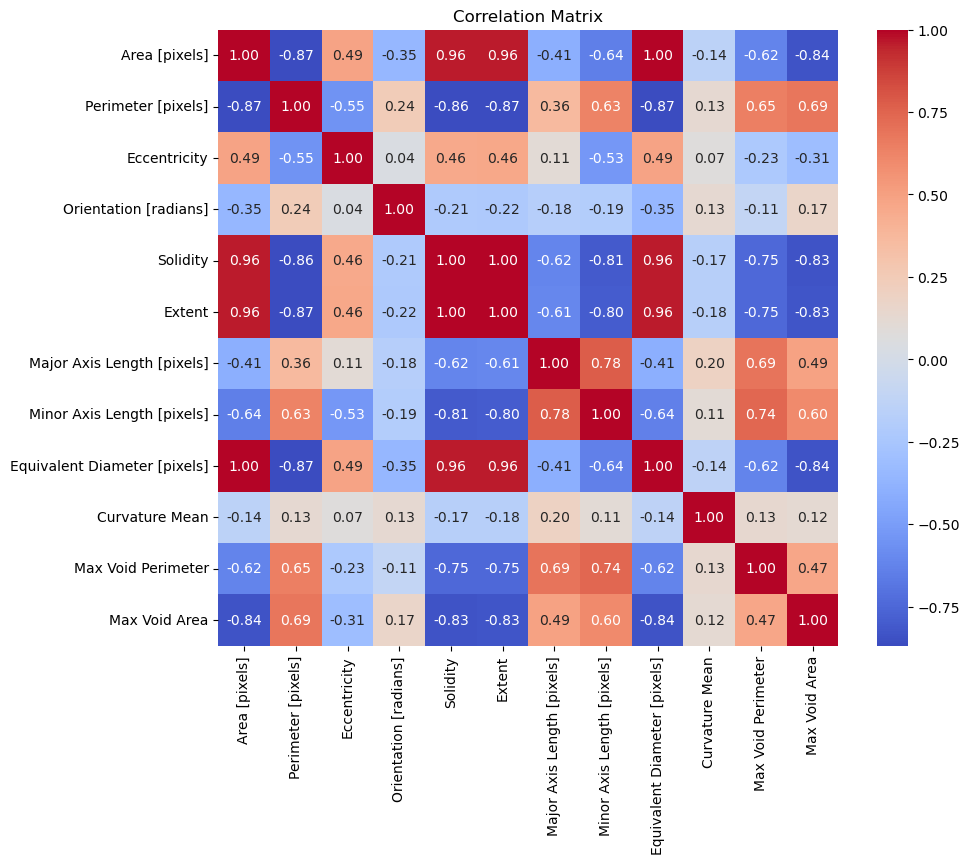

In [22]:
data = df_new_parts.copy()
data = data.drop(columns=["ID","Part_ID","Num_voids"])
cor_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Normality assumption

In [18]:
for col in df_new_parts.columns[4:]:
	summary_assumptions(df_new_parts[col],col,0)
	print("")

(Area [pixels]) Normality p-value = 0.7310476303100586 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.024927044113953436 - Random data at alpha 5%? False

(Perimeter [pixels]) Normality p-value = 0.8690754771232605 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 0.025599049061790877 - Random data at alpha 5%? False

(Eccentricity) Normality p-value = 0.09720978140830994 - Normality at alpha 5%? True
(Eccentricity) Runs test p-value = 0.1933261617649059 - Random data at alpha 5%? True

(Orientation [radians]) Normality p-value = 9.760273087522364e-07 - Normality at alpha 5%? False
(Orientation [radians]) Runs test p-value = 0.049028818261799306 - Random data at alpha 5%? False

(Solidity) Normality p-value = 0.26717373728752136 - Normality at alpha 5%? True
(Solidity) Runs test p-value = 0.0039358900854266484 - Random data at alpha 5%? False

(Extent) Normality p-value = 0.3694446086883545 - Normality at alpha 5%? True
(Extent) Runs test p-val

Selection

(array([ 1.,  0.,  1.,  3.,  1., 10., 10.,  6.,  7.,  1.]),
 array([0.018 , 0.0351, 0.0522, 0.0693, 0.0864, 0.1035, 0.1206, 0.1377,
        0.1548, 0.1719, 0.189 ]),
 <BarContainer object of 10 artists>)

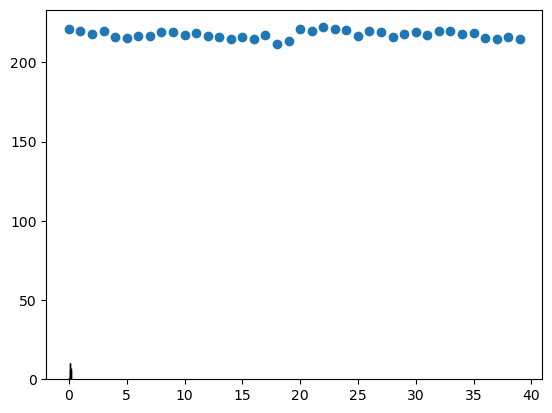

In [16]:
#useful plots 
#used them iteratively to look at all variable disposition graphically
#here only examples

plt.plot(df_new_parts['Part_ID'], df_new_parts['Equivalent Diameter [pixels]'], 'o')
plt.hist(df_new_parts['Eccentricity'], color='skyblue', edgecolor='black')

In [17]:
# Not normal
data_part_norm = data.drop(columns=['Orientation [radians]'])  # remove also Num_Wpixels, same info of Area

In [18]:
data_part_norm.corr()

Area [pixels]  Perimeter [pixels]  Eccentricity  \
Area [pixels]                      1.000000           -0.868500      0.487220   
Perimeter [pixels]                -0.868500            1.000000     -0.550430   
Eccentricity                       0.487220           -0.550430      1.000000   
Solidity                           0.959698           -0.864030      0.458303   
Extent                             0.958566           -0.867636      0.460953   
Major Axis Length [pixels]        -0.405992            0.358189      0.107364   
Minor Axis Length [pixels]        -0.642584            0.631061     -0.525895   
Equivalent Diameter [pixels]       0.999978           -0.868537      0.486802   
Curvature Mean                    -0.139222            0.128158      0.073735   
Max Void Perimeter                -0.622749            0.645233     -0.226312   
Max Void Area                     -0.836554            0.685797     -0.311514   
White Pixels Ratio                 0.948576           -0.826997      0.427530   

                              Solidity    Extent  Major Axis Length [pixels]  \
Area [pixels]                 0.959698  0.958566                   -0.405992   
Perimeter [pixels]           -0.864030 -0.867636                    0.358189   
Eccentricity                  0.458303  0.460953                    0.107364   
Solidity                      1.000000  0.997646                   -0.620355   
Extent                        0.997646  1.000000                   -0.608374   
Major Axis Length [pixels]   -0.620355 -0.608374                    1.000000   
Minor Axis Length [pixels]   -0.809900 -0.800234                    0.776953   
Equivalent Diameter [pixels]  0.959639  0.958493                   -0.406034   
Curvature Mean               -0.172651 -0.175008                    0.196605   
Max Void Perimeter           -0.745521 -0.748971                    0.693430   
Max Void Area                -0.834021 -0.831936                    0.491708   
White Pixels Ratio            0.990632  0.988958                   -0.639180   

                              Minor Axis Length [pixels]  \
Area [pixels]                                  -0.642584   
Perimeter [pixels]                              0.631061   
Eccentricity                                   -0.525895   
Solidity                                       -0.809900   
Extent                                         -0.800234   
Major Axis Length [pixels]                      0.776953   
Minor Axis Length [pixels]                      1.000000   
Equivalent Diameter [pixels]                   -0.642224   
Curvature Mean                                  0.107938   
Max Void Perimeter                              0.738041   
Max Void Area                                   0.599534   
White Pixels Ratio                             -0.803835   

                              Equivalent Diameter [pixels]  Curvature Mean  \
Area [pixels]                                     0.999978       -0.139222   
Perimeter [pixels]                               -0.868537        0.128158   
Eccentricity                                      0.486802        0.073735   
Solidity                                          0.959639       -0.172651   
Extent                                            0.958493       -0.175008   
Major Axis Length [pixels]                       -0.406034        0.196605   
Minor Axis Length [pixels]                       -0.642224        0.107938   
Equivalent Diameter [pixels]                      1.000000       -0.138024   
Curvature Mean                                   -0.138024        1.000000   
Max Void Perimeter                               -0.621560        0.133991   
Max Void Area                                    -0.836711        0.122864   
White Pixels Ratio                                0.948515       -0.177102   

                              Max Void Perimeter  Max Void Area  \
Area [pixels]                          -0.622749      -0.836554   
Perim

In [19]:
data_part_norm = data_part_norm.drop(columns=['Solidity','Extent', 'Equivalent Diameter [pixels]'])
data_part_norm.head(10)

Image name      Position Region type  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp      top_left        part          38291            4105.674   
1  img01.bmp   bottom_left        part          37887            4155.306   
2  img01.bmp     top_right        part          37334            4106.076   
3  img01.bmp  bottom_right        part          37868            4139.319   
4  img02.bmp      top_left        part          36599            4223.005   
5  img02.bmp   bottom_left        part          36382            4305.088   
6  img02.bmp     top_right        part          36808            4366.544   
7  img02.bmp  bottom_right        part          36903            4180.034   
8  img03.bmp      top_left        part          37697            4124.720   
9  img03.bmp   bottom_left        part          37626            4153.833   

   Eccentricity  Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0         0.153                     277.925                     274.667   
1         0.157                     279.026                     275.584   
2         0.189                     277.777                     272.791   
3         0.164                     277.900                     274.158   
4         0.118                     280.140                     278.182   
5         0.104                     280.715                     279.187   
6         0.067                     278.233                     277.617   
7         0.127                     279.169                     276.892   
8         0.123                     277.368                     275.259   
9         0.117                     277.820                     275.897   

   Curvature Mean  Max Void Perimeter  Max Void Area  White Pixels Ratio  
0        0.006382             114.740          603.0            0.736606  
1        0.006624             116.326          633.0            0.728834  
2        0.006660             112.326          647.0            0.724538  
3        0.005039             114.154          651.0            0.734887  
4        0.006398             117.983          672.0            0.704044  
5        0.006654             118.569          687.0            0.699869  
6        0.005715             115.154          674.0            0.714316  
7        0.005634             114.083          681.0            0.709892  
8        0.005471             114.326          630.0            0.728360  
9        0.006325             114.326          615.0            0.726988

In [20]:
dataNum = data_part_norm.select_dtypes(include=np.number)
dataNum.head(10)

Area [pixels]  Perimeter [pixels]  Eccentricity  \
0          38291            4105.674         0.153   
1          37887            4155.306         0.157   
2          37334            4106.076         0.189   
3          37868            4139.319         0.164   
4          36599            4223.005         0.118   
5          36382            4305.088         0.104   
6          36808            4366.544         0.067   
7          36903            4180.034         0.127   
8          37697            4124.720         0.123   
9          37626            4153.833         0.117   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  Curvature Mean  \
0                     277.925                     274.667        0.006382   
1                     279.026                     275.584        0.006624   
2                     277.777                     272.791        0.006660   
3                     277.900                     274.158        0.005039   
4                     280.140                     278.182        0.006398   
5                     280.715                     279.187        0.006654   
6                     278.233                     277.617        0.005715   
7                     279.169                     276.892        0.005634   
8                     277.368                     275.259        0.005471   
9                     277.820                     275.897        0.006325   

   Max Void Perimeter  Max Void Area  White Pixels Ratio  
0             114.740          603.0            0.736606  
1             116.326          633.0            0.728834  
2             112.326          647.0            0.724538  
3             114.154          651.0            0.734887  
4             117.983          672.0            0.704044  
5             118.569          687.0            0.699869  
6             115.154          674.0            0.714316  
7             114.083          681.0            0.709892  
8             114.326          630.0            0.728360  
9             114.326          615.0            0.726988

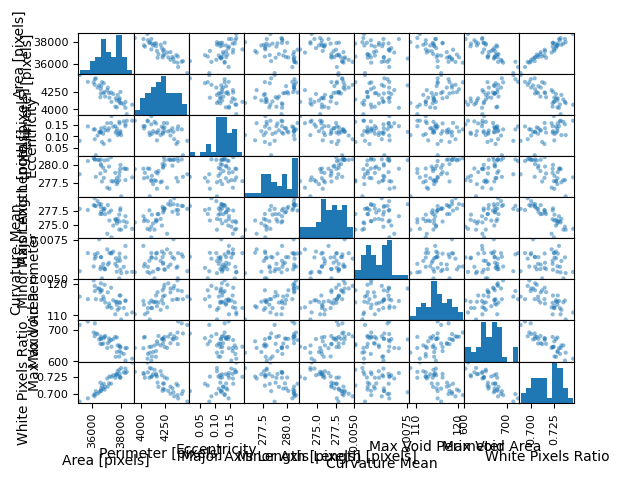

In [21]:
#Scatter plot
dataset=dataNum
pd.plotting.scatter_matrix(dataset)
plt.show()

# can see some linear correlated vars and some very sparse/uncorrelated

## PCA

In [25]:
# Correlation matrix
cov_matrix = dataset.cov()
#print(cov_matrix)

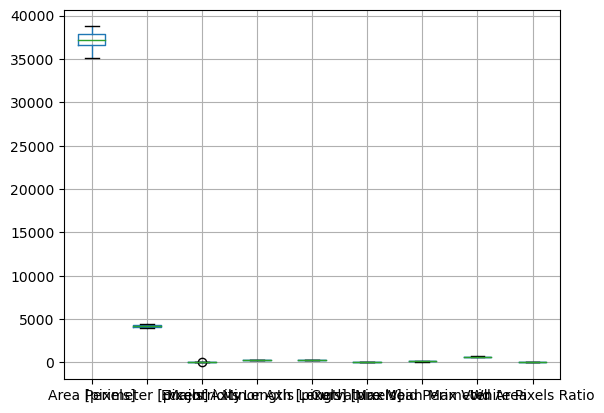

In [26]:
#Boxplot
dataset.boxplot()
plt.show() 
# need to scale vars

In [27]:
# Standardize the data
data_std = (dataset - dataset.mean()) / dataset.std()
data_std.head(10)

Area [pixels]  Perimeter [pixels]  Eccentricity  \
0       1.374602           -0.839314      0.834630   
1       0.873789           -0.456789      0.957370   
2       0.188270           -0.836215      1.939288   
3       0.850236           -0.580004      1.172164   
4      -0.722863            0.064983     -0.239342   
5      -0.991864            0.697615     -0.668932   
6      -0.463779            1.171270     -1.804274   
7      -0.346014           -0.266204      0.036822   
8       0.638258           -0.692522     -0.085918   
9       0.550244           -0.468141     -0.270027   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  Curvature Mean  \
0                   -0.835879                   -1.221151        0.481009   
1                   -0.028135                   -0.670558        0.906485   
2                   -0.944459                   -2.347555        0.970252   
3                   -0.854220                   -1.526769       -1.877498   
4                    0.789146                    0.889354        0.509576   
5                    1.210992                    1.492785        0.958546   
6                   -0.609916                    0.550112       -0.689848   
7                    0.076776                    0.114802       -0.832679   
8                   -1.244520                   -0.865698       -1.119784   
9                   -0.912912                   -0.482624        0.380388   

   Max Void Perimeter  Max Void Area  White Pixels Ratio  
0           -0.142918      -1.994936            1.381585  
1            0.395262      -0.954552            0.828088  
2           -0.962063      -0.469040            0.522110  
3           -0.341766      -0.330322            1.259156  
4            0.957533       0.397947           -0.937490  
5            1.156382       0.918139           -1.234783  
6           -0.002435       0.467306           -0.205883  
7           -0.365858       0.710062           -0.521005  
8           -0.283401      -1.058591            0.794300  
9           -0.283401      -1.578783            0.696600

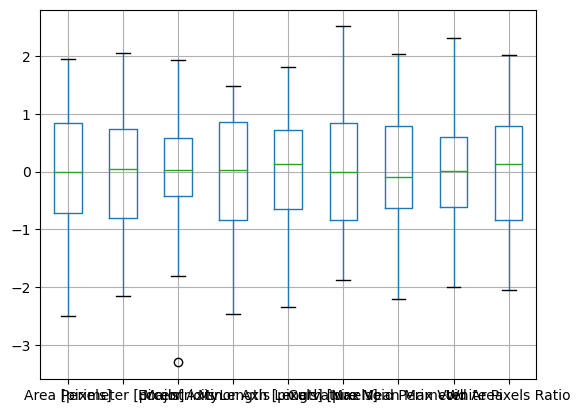

In [28]:
#cov matrix
cov_matrix_std = data_std.cov()

#Boxplot
data_std.boxplot()
plt.show() 

In [29]:
# Create the PCA object
pca = PCA()
# Fit the PCA object to the data
pca.fit(data_std)

#print("Eigenvalues \n", pca.explained_variance_)
#print("\nEigenvectors \n", pca.components_)
#print("\nExplained variance ratio \n", pca.explained_variance_ratio_)

print("\nCumulative explained variance ratio \n", np.cumsum(pca.explained_variance_ratio_))



Cumulative explained variance ratio 
 [0.59352304 0.74332135 0.84693203 0.92232697 0.96811402 0.98467343
 0.99800429 0.99913451 1.        ]


In [30]:
# Compute the scores (i.e. all the principal components, n x 3) 
scores = pca.transform(data_std)
# create a dataframe with the scores
scores_df = pd.DataFrame(scores)
# Print the first rows of the scores dataframe
scores_df.head()

0         1         2         3         4         5         6  \
0  3.044326 -0.637005  0.337837 -0.820084 -1.073836 -0.045505 -0.061493   
1  1.462209 -1.276225  0.475229 -0.479443 -0.794970  0.109501  0.215051   
2  2.607889 -0.882739  1.537339  1.591013 -0.700368  0.111996 -0.472083   
3  2.547546  0.388660 -1.314422  1.282340 -0.731242  0.190942  0.489587   
4 -1.835083 -0.624466  0.006731 -0.347635  0.076307  0.389595 -0.417866   

          7         8  
0  0.029597 -0.024787  
1  0.026794  0.023647  
2  0.222816  0.086555  
3 -0.003296  0.079710  
4  0.007481 -0.029514

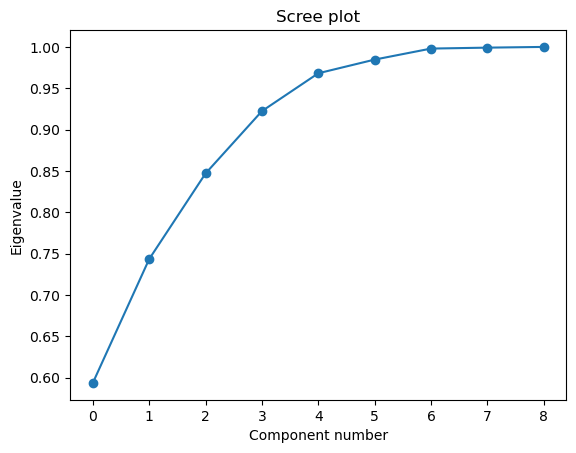

In [31]:
# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.title('Scree plot')
plt.show()

# keeping 4 or 5 pcs should be enough (more than 95% variability explained)

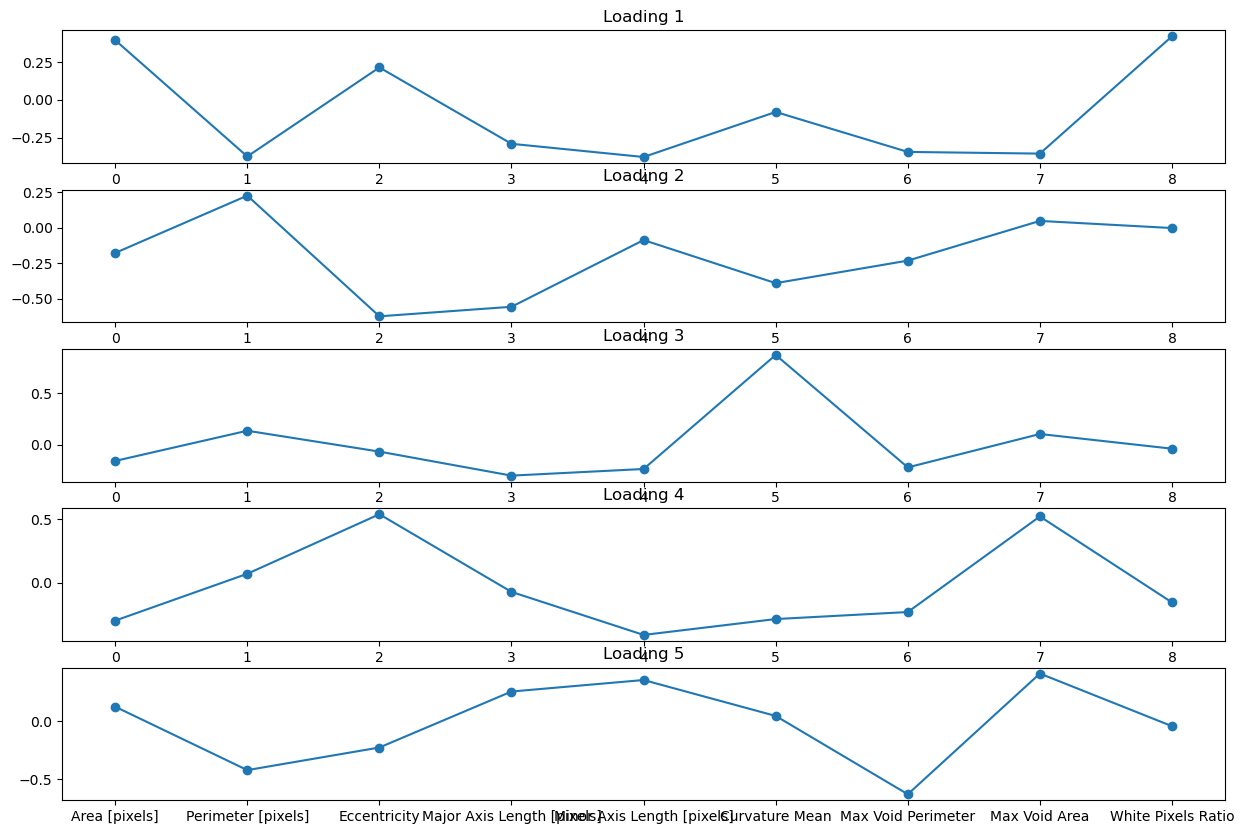

In [32]:
# Loadings
# Plot only the first k PCs
k = 5
fig, ax = plt.subplots(k,1, figsize = (15, 10))
for i in range(k):
   ax[i].plot(pca.components_[i], 'o-')
   ax[i].set_title('Loading ' + str(i+1))
   plt.xticks(ticks=np.arange(0, 9, step=1), labels=dataset.columns)


In [33]:
# PCs normality
for col in scores_df.columns:
    dataset = scores_df.loc[:, col].values
    _, p_value_SW = stats.shapiro(dataset)
    print('p-value of the Shapiro-Wilk test for "{}": {:.3f}'.format(col, float(p_value_SW)))

#some normal, some not
#we interested in 0 to 4, but "1" and "2" not normal 


p-value of the Shapiro-Wilk test for "0": 0.067
p-value of the Shapiro-Wilk test for "1": 0.006
p-value of the Shapiro-Wilk test for "2": 0.191
p-value of the Shapiro-Wilk test for "3": 0.341
p-value of the Shapiro-Wilk test for "4": 0.906
p-value of the Shapiro-Wilk test for "5": 0.872
p-value of the Shapiro-Wilk test for "6": 0.383
p-value of the Shapiro-Wilk test for "7": 0.001
p-value of the Shapiro-Wilk test for "8": 0.003


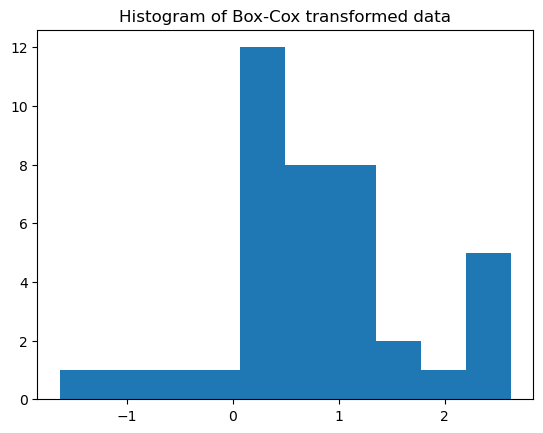

p-value of the Shapiro-Wilk test for "transf_1": 0.084


In [34]:
# Box-Cox 
dat = scores_df.loc[:, 1].values
dat=dat+np.abs(dat.min())+0.001
[transf_1, lmbda] = stats.boxcox(dat) 
# If lmbda is None (default), find the value of lmbda that maximizes the log-likelihood function and return it as the second output argument.

plt.hist(transf_1)
plt.title('Histogram of Box-Cox transformed data')
plt.show()

col = 'transf_1'
_, p_value_SW = stats.shapiro(transf_1)
print('p-value of the Shapiro-Wilk test for "{}": {:.3f}'.format(col, float(p_value_SW)))

# normal

## Randomness

In [21]:
for col in df_new_parts.columns[4:]:
   _, pval_runs = runstest_1samp(df_new_parts[col], correction=False)
   print('Runs test p-value for', col ,' = {:.3f}'.format(pval_runs))
   if pval_runs<0.05:
     print('The null hypothesis is rejected: the process is not random')
   else:
     print('The null hypothesis is accepted: the process is random')

Runs test p-value for Area [pixels]  = 0.025
The null hypothesis is rejected: the process is not random
Runs test p-value for Perimeter [pixels]  = 0.026
The null hypothesis is rejected: the process is not random
Runs test p-value for Eccentricity  = 0.193
The null hypothesis is accepted: the process is random
Runs test p-value for Orientation [radians]  = 0.049
The null hypothesis is rejected: the process is not random
Runs test p-value for Solidity  = 0.004
The null hypothesis is rejected: the process is not random
Runs test p-value for Extent  = 0.004
The null hypothesis is rejected: the process is not random
Runs test p-value for Major Axis Length [pixels]  = 0.749
The null hypothesis is accepted: the process is random
Runs test p-value for Minor Axis Length [pixels]  = 0.032
The null hypothesis is rejected: the process is not random
Runs test p-value for Equivalent Diameter [pixels]  = 0.025
The null hypothesis is rejected: the process is not random
Runs test p-value for Part_ID  

# SPCs

First attempts

In [ ]:
## Code to break dataset using trays as samples

#m=10   #number of trays
#n=4    #elements per tray
#data_tray=np.array(data['Area [pixels]']).reshape(m,n)
#data_tray=pd.DataFrame(data_tray)
#data_tray.head()

## Xbar-R control charts
#data_XR = qda.ControlCharts.XbarR(data_tray)



## I-MR-R control chart
## Create a new dataframe that stores the mean of all the samples
#data_Xbar = pd.DataFrame(data_XR['sample_mean'])
#data_Xbar.head()
#data_Xbar = qda.ControlCharts.IMR(data_Xbar, 'sample_mean')
## Plot the R chart as well
#plt.title('R chart')
#plt.plot(data_XR['sample_range'], color='b', linestyle='--', marker='o')
#plt.plot(data_XR['R_UCL'], color='r')
#plt.plot(data_XR['R_CL'], color='g')
#plt.plot(data_XR['R_LCL'], color='r')
#plt.ylabel('Sample range')
#plt.xlabel('Sample number')
## add the values of the control limits on the right side of the plot
#plt.text(len(data_XR)+.5, data_XR['R_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['R_UCL'].iloc[0]), verticalalignment='center')
#plt.text(len(data_XR)+.5, data_XR['R_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['R_CL'].iloc[0]), verticalalignment='center')
#plt.text(len(data_XR)+.5, data_XR['R_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['R_LCL'].iloc[0]), verticalalignment='center')
## highlight the points that violate the alarm rules
#plt.plot(data_XR['R_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
#plt.show()

#problems with independence

## Idea 1: Under time series assumptions, bulding SPC, SCC and FVC 

### Area

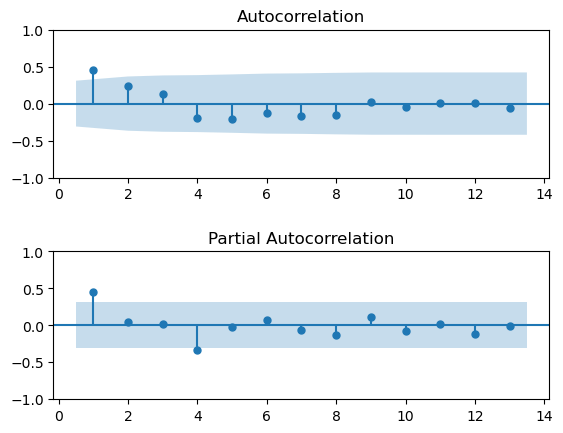

Runs test p-value = 0.025


In [48]:
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Area [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Area [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Area [pixels]'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Not iid --> AR(1) model

In [20]:
df_new_parts['Area_lag1'] = df_new_parts['Area [pixels]'].shift(1)

# Fit the linear regression model
import statsmodels.api as sm

x = df_new_parts['Area_lag1'][1:]
x = sm.add_constant(x)
y = df_new_parts['Area [pixels]'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
Area [pixels] =  + 19717.318 const + 0.469 Area_lag1

COEFFICIENTS
------------
     Term       Coef   SE Coef  T-Value  P-Value
    const 19717.3183 5367.5324   3.6734   0.0008
Area_lag1     0.4686    0.1442   3.2492   0.0025

MODEL SUMMARY
-------------
       S  R-sq  R-sq(adj)
712.1326 0.222      0.201

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS  F-Value  P-Value
Regression  1.0 5.3540e+06 5.3540e+06  10.5575   0.0025
     const  1.0 6.8433e+06 6.8433e+06  13.4942   0.0008
 Area_lag1  1.0 5.3540e+06 5.3540e+06  10.5575   0.0025
     Error 37.0 1.8764e+07 5.0713e+05      NaN      NaN
     Total 38.0 2.4118e+07        NaN      NaN      NaN


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


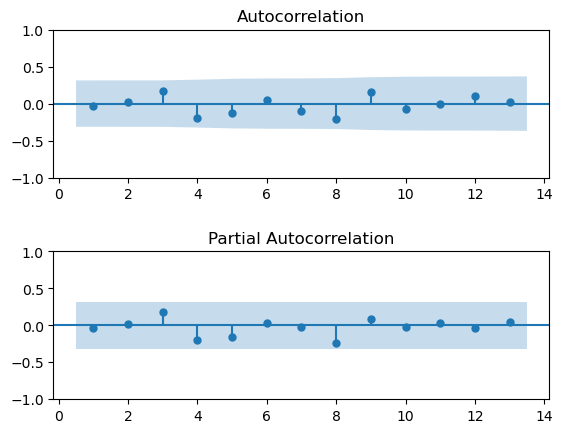

Runs test p-value = 0.254


In [50]:
# Check the autocorrelation of the residuals
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

_, pval_runs_resid = runstest_1samp(model.resid, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs_resid))


Shapiro-Wilk test p-value on the residuals = 0.496


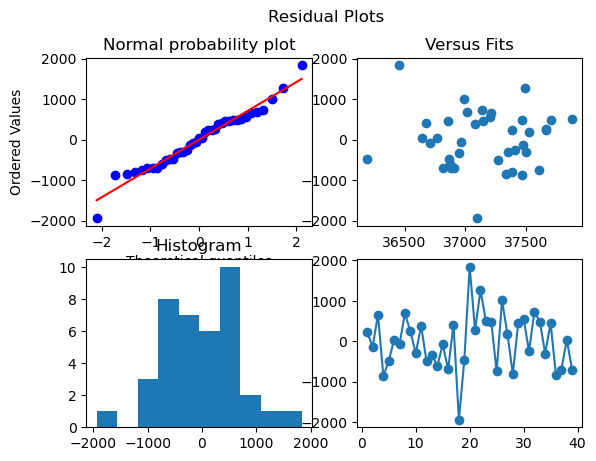

In [51]:
# Plot the residuals and test for normality
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

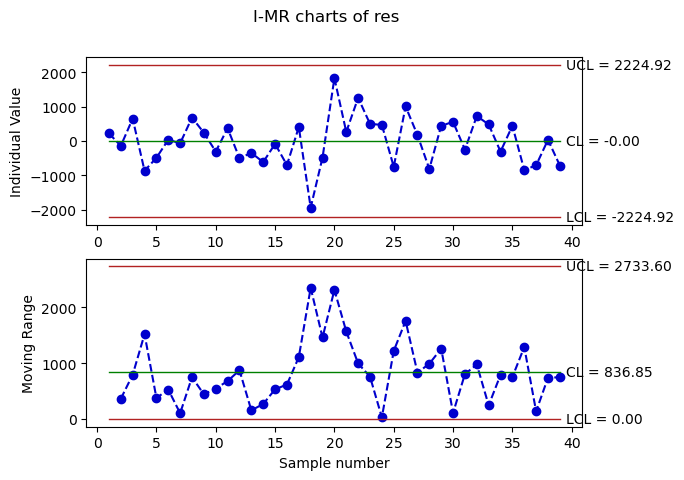

In [52]:
# SCC
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(model.resid, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

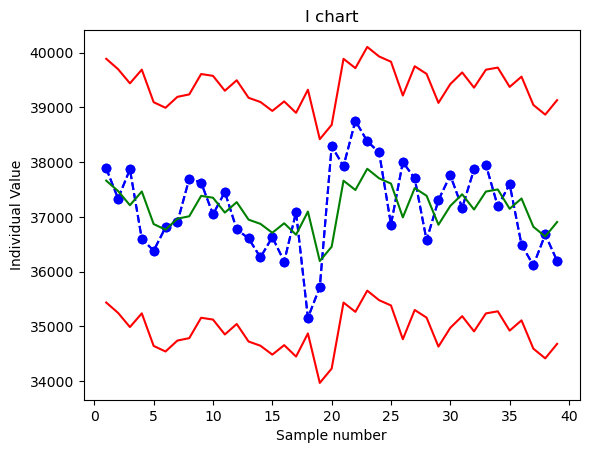

In [53]:
# FVC
d2 = qda.constants.getd2(2)

MRbar_res = df_SCC_IMR['MR_CL'].iloc[0]

# Create a new dataframe with the original data and the center line (the fitted values)
df = pd.DataFrame({'I': df_new_parts['Area [pixels]'].iloc[1:], 'I_CL': model.fittedvalues}, index=df_new_parts.index[1:])

# Add the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * MRbar_res / d2
df['I_LCL'] = df['I_CL'] - 3 * MRbar_res / d2

# Add the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

### Perimeter [pixels]

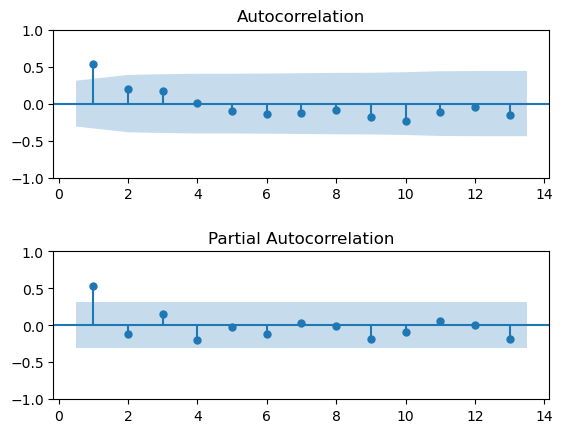

Runs test p-value = 0.026


In [54]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Perimeter [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Perimeter [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Perimeter [pixels]'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Not iid

In [55]:
df_new_parts['Per_lag1'] = df_new_parts['Perimeter [pixels]'].shift(1)

# Fit the linear regression model
import statsmodels.api as sm

x = df_new_parts['Per_lag1'][1:]
x = sm.add_constant(x)
y = df_new_parts['Perimeter [pixels]'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
Perimeter [pixels] =  + 1808.237 const + 0.572 Per_lag1

COEFFICIENTS
------------
    Term      Coef  SE Coef  T-Value  P-Value
   const 1808.2371 589.5691   3.0670   0.0040
Per_lag1    0.5723   0.1400   4.0881   0.0002

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
109.531 0.3111     0.2925

ANALYSIS OF VARIANCE
---------------------
    Source   DF      Adj SS      Adj MS  F-Value  P-Value
Regression  1.0 200497.4740 200497.4740  16.7123   0.0002
     const  1.0 112853.5153 112853.5153   9.4068   0.0040
  Per_lag1  1.0 200497.4740 200497.4740  16.7123   0.0002
     Error 37.0 443890.1803  11997.0319      NaN      NaN
     Total 38.0 644387.6543         NaN      NaN      NaN


c:\Users\giuli\.conda\envs\qda_environment_v2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


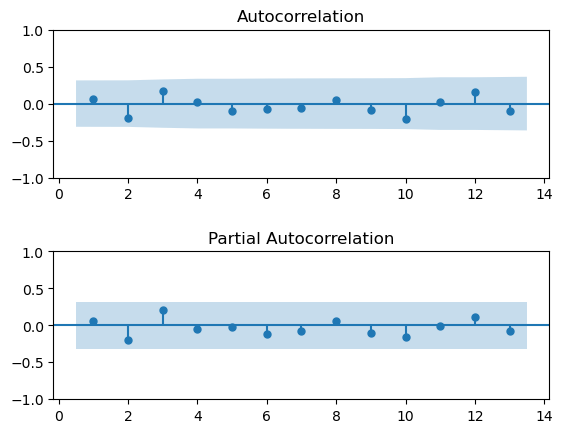

Runs test p-value = 0.436


In [56]:
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

_, pval_runs_resid = runstest_1samp(model.resid, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs_resid))

Shapiro-Wilk test p-value on the residuals = 0.685


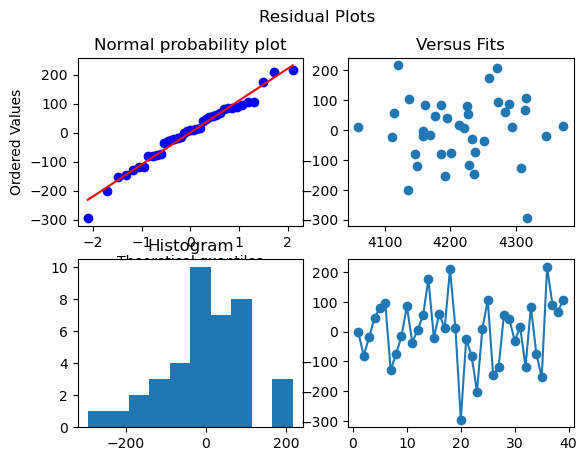

In [57]:
# Plot the residuals and test for normality
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

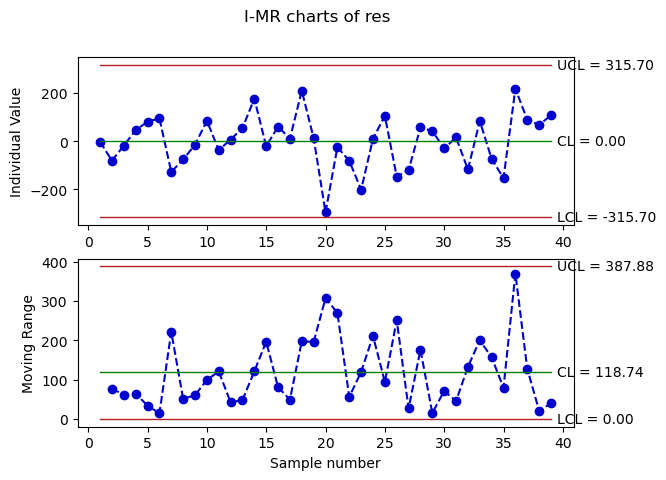

In [58]:
# SCC
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(model.resid, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

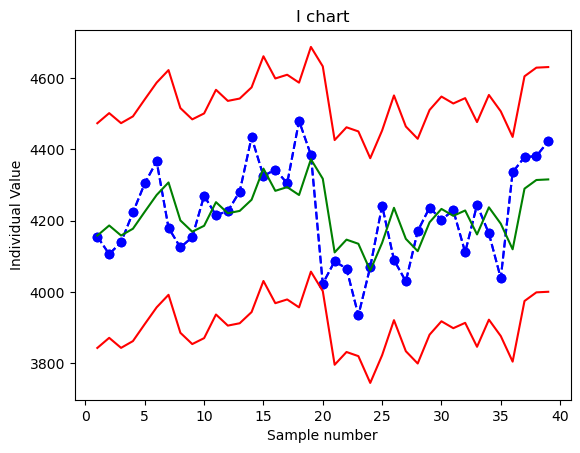

In [59]:
# FVC
d2 = qda.constants.getd2(2)

MRbar_res = df_SCC_IMR['MR_CL'].iloc[0]

# Create a new dataframe with the original data and the center line (the fitted values)
df = pd.DataFrame({'I': df_new_parts['Perimeter [pixels]'].iloc[1:], 'I_CL': model.fittedvalues}, index=df_new_parts.index[1:])

# Add the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * MRbar_res / d2
df['I_LCL'] = df['I_CL'] - 3 * MRbar_res / d2

# Add the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

### Major Axis Length [pixels]

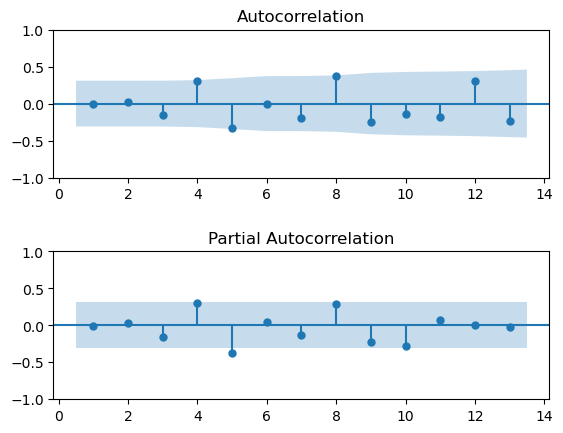

Runs test p-value = 0.749


In [60]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Major Axis Length [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Major Axis Length [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Major Axis Length [pixels]'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))


# The assumptions are satisfied --> SPC

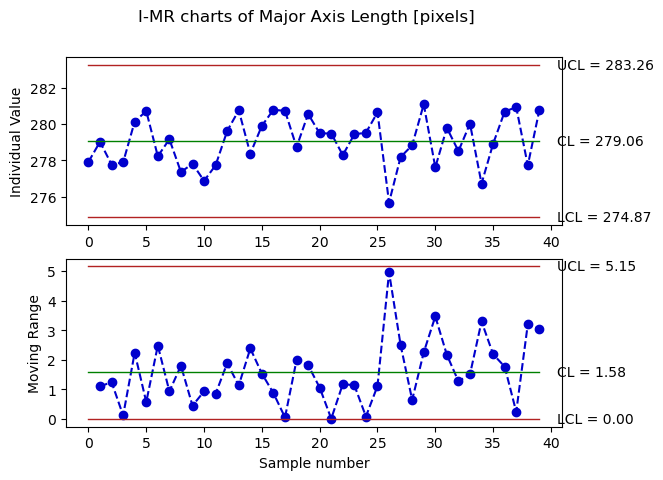

In [61]:
data_IMR = qda.ControlCharts.IMR(df_new_parts, 'Major Axis Length [pixels]')

### Curvature Mean

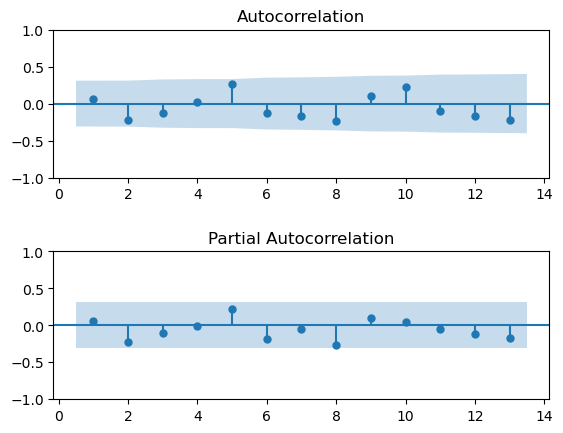

Runs test p-value = 0.522


In [62]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Curvature Mean'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Curvature Mean'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Curvature Mean'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# The assumptions are satisfied --> SPC

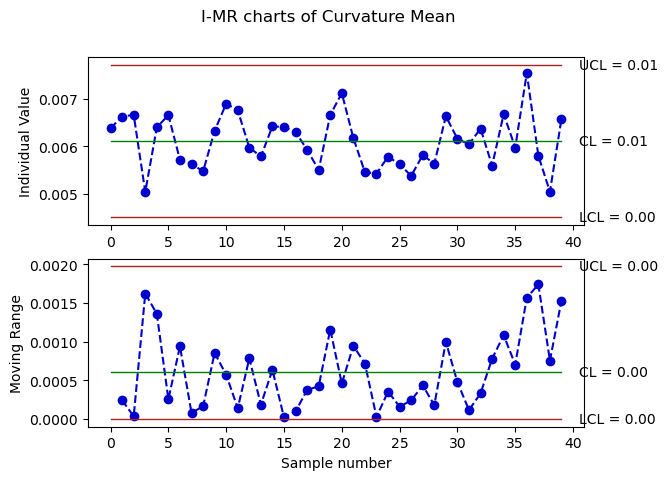

In [63]:
data_IMR = qda.ControlCharts.IMR(df_new_parts, 'Curvature Mean')

### Max Void Perimeter

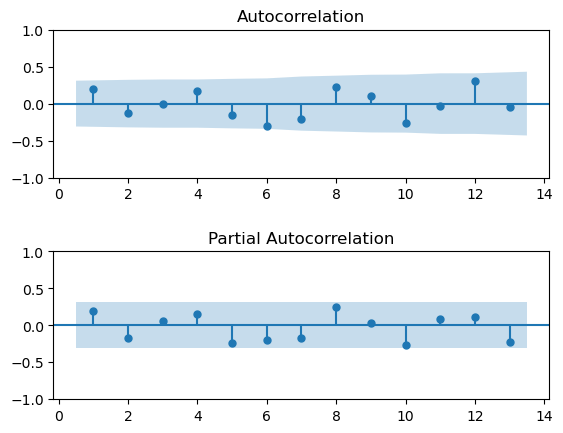

Runs test p-value = 0.161


In [64]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Max Void Perimeter'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Max Void Perimeter'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Max Void Perimeter'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# The assumptions are not satisfied


In [ ]:
data_IMR = qda.ControlCharts.IMR(df_new_parts, 'Max Void Perimeter')

### Max Void Area

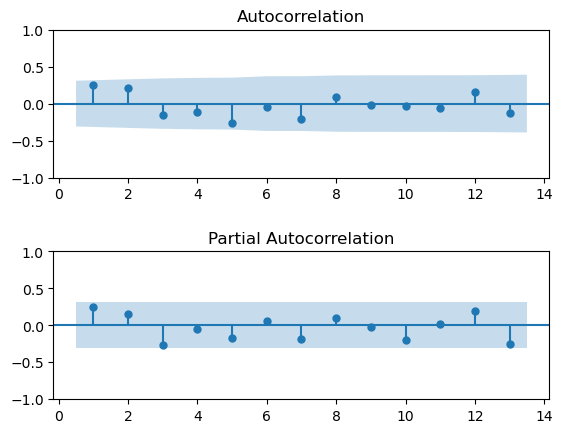

Runs test p-value = 0.749


In [66]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Max Void Area'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Max Void Area'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Max Void Area'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

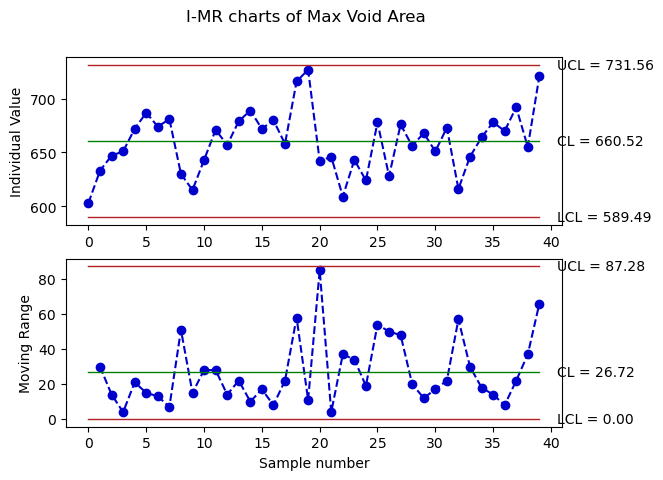

In [67]:
data_IMR = qda.ControlCharts.IMR(df_new_parts, 'Max Void Area')

## Idea 2: indipendence through shuffle

In [51]:
df_new_parts.columns

Index(['Image name', 'Position', 'Region type', 'ID', 'Area [pixels]',
       'Perimeter [pixels]', 'Eccentricity', 'Orientation [radians]',
       'Solidity', 'Extent', 'Major Axis Length [pixels]',
       'Minor Axis Length [pixels]', 'Equivalent Diameter [pixels]', 'Part_ID',
       'Num_voids', 'Curvature Mean', 'Max Void Perimeter', 'Max Void Area'],
      dtype='object')

In [171]:
candidate_variables = ["Area [pixels]", "Perimeter [pixels]", "Major Axis Length [pixels]", 'Curvature Mean', 'Max Void Perimeter', 'Max Void Area']
for relvar in candidate_variables:
	summary_assumptions(df_new_parts[relvar],relvar,0)
	print()

(Area [pixels]) Normality p-value = 0.42154160141944885 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.04328246701271295 - Random data at alpha 5%? False

(Perimeter [pixels]) Normality p-value = 0.9709747433662415 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 1.9307220920869607e-05 - Random data at alpha 5%? False

(Major Axis Length [pixels]) Normality p-value = 0.04708345606923103 - Normality at alpha 5%? False
(Major Axis Length [pixels]) Runs test p-value = 0.26260242923260857 - Random data at alpha 5%? True

(Curvature Mean) Normality p-value = 2.01355007334314e-07 - Normality at alpha 5%? False
(Curvature Mean) Runs test p-value = 0.11627149959025725 - Random data at alpha 5%? True

(Max Void Perimeter) Normality p-value = 1.3253247006592526e-18 - Normality at alpha 5%? False
(Max Void Perimeter) Runs test p-value = 0.11467088857401628 - Random data at alpha 5%? True

(Max Void Area) Normality p-value = 4.7660906124386625e-18 - Norma

In [183]:
chosen_variables = [
	"Area [pixels]",
    "Perimeter [pixels]",
	"Major Axis Length [pixels]",
	'Curvature Mean',
	'Max Void Perimeter',
	'Max Void Area']
seed = 99 # to get the same one of the report/phase 1

## phase 1
# df_shuffled = df_new_parts.sample(frac=1,random_state=seed).reset_index(drop=True)

## phase 2
# Dividi il DataFrame in due parti: prime 40 righe e ultime 40 righe
first_40_rows = df_new_parts.iloc[0:40]
last_40_rows = df_new_parts.iloc[40:]

# Fai lo shuffle delle prime 40 righe
shuffled_first_40_rows = first_40_rows.sample(frac=1,random_state=seed).reset_index(drop=True)

# Riunisci le righe shuffle-ate con le ultime 40 righe
df_shuffled = pd.concat([shuffled_first_40_rows, last_40_rows]).reset_index(drop=True)

In [109]:
# df_new_parts.to_csv("New_dataset.csv")

In [184]:
for chosvar in chosen_variables:
	summary_assumptions(shuffled_first_40_rows[chosvar],chosvar,0)
	print()

(Area [pixels]) Normality p-value = 0.7310476303100586 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.7486942029213925 - Random data at alpha 5%? True

(Perimeter [pixels]) Normality p-value = 0.8690754771232605 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 0.7602698494425246 - Random data at alpha 5%? True

(Major Axis Length [pixels]) Normality p-value = 0.09676539897918701 - Normality at alpha 5%? True
(Major Axis Length [pixels]) Runs test p-value = 0.7486942029213925 - Random data at alpha 5%? True

(Curvature Mean) Normality p-value = 0.5501565337181091 - Normality at alpha 5%? True
(Curvature Mean) Runs test p-value = 0.3365094747160182 - Random data at alpha 5%? True

(Max Void Perimeter) Normality p-value = 0.9064947962760925 - Normality at alpha 5%? True
(Max Void Perimeter) Runs test p-value = 0.08235221505280674 - Random data at alpha 5%? True

(Max Void Area) Normality p-value = 0.5666319727897644 - Normality at alpha 5%? True


In [ ]:
# for seed in range(1,100):
# 	df_shuffled = first_40_rows.sample(frac=1,random_state=seed).reset_index(drop=True)
# 	va_bene = True
# 	for chosvar in chosen_variables:
# 		data=pd.DataFrame(df_shuffled[chosvar])
# 		data_IMR = qda.ControlCharts.IMR(data,chosvar,plotit=False);
# 		va_bene = va_bene & data_IMR["I_TEST1"].isna().all() & data_IMR["MR_TEST1"].isna().all()
# 	if va_bene==True:
# 		print(seed)

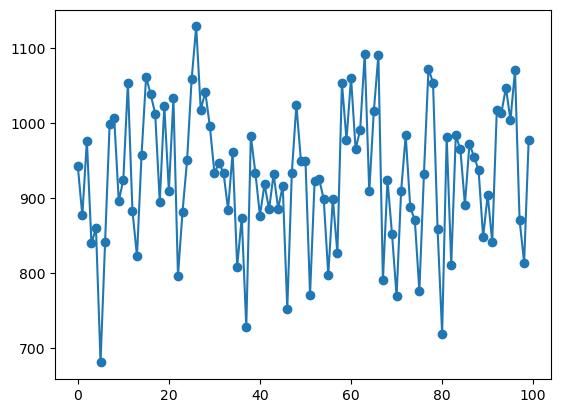

In [23]:
chosvar = "Area [pixels]"
MRs = np.zeros(100)
for seed in range(0,100):
	df_shuffled = df_new_parts.sample(frac=1,random_state=seed).reset_index(drop=True)
	df = pd.DataFrame(df_shuffled[chosvar])
	df['MR'] = df[chosvar].diff().abs()
	MRs[seed] = df['MR'].mean()

plt.plot(MRs,'o-')

### With bonferroni correction since multiple charts

In [185]:
# with different alpha/k
n_var=len(chosen_variables)
alpha = 0.0027/n_var
K_alpha = stats.norm.ppf(1-alpha/2)

print(n_var)
print(K_alpha)

6
3.5088787519844318


In [ ]:
#### NEED TO UPDATE CODE HERE
## or use the next code section

# manually and just the I one
d2 = 1.128
plt.figure(figsize=(16,24))
# plt.figure(figsize=(8.2, 11.69),dpi=100)
# add subplots structure
for i,chosvar in enumerate(chosen_variables,start=1):
	df = pd.DataFrame(shuffled_first_40_rows[chosvar])
	df['MR'] = df[chosvar].diff().abs()
	df['I_UCL'] = df[chosvar].mean() + (K_alpha*df['MR'].mean()/d2)
	df['I_CL'] = df[chosvar].mean()
	df['I_LCL'] = df[chosvar].mean() - (K_alpha*df['MR'].mean()/d2)
	df['I_TEST1'] = np.where((df[chosvar] > df['I_UCL']) |
	(df[chosvar] < df['I_LCL']), df[chosvar], np.nan)
	# df.head()

	# Plot the I chart
	plt.subplot(4,2,i)
	plt.title(f'I chart for {chosvar}')
	plt.plot(df[chosvar], color='b', linestyle='--', marker='o')
	plt.plot(df[chosvar], color='b', linestyle='--', marker='o')
	plt.plot(df['I_UCL'], color='r')
	plt.plot(df['I_CL'], color='g')
	plt.plot(df['I_LCL'], color='r')
	plt.ylabel('Individual Value',fontsize=8)
	plt.xlabel('Sample number',fontsize=8)
	# add the values of the control limits on the right side of the plot
	if chosvar == "Curvature Mean":
		plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.5f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
		plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.5f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
		plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.5f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
	else:
		plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.3f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
		plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.3f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
		plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.3f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
	# highlight the points that violate the alarm rules
	plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
	# plt.show()

plt.subplots_adjust(wspace=0.36) 
plt.subplots_adjust(hspace=0.3) 


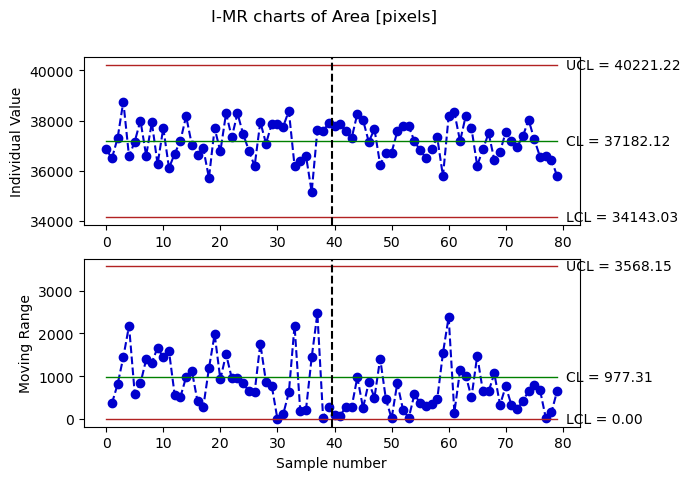

The index of the OOC point is: [] from Area [pixels]


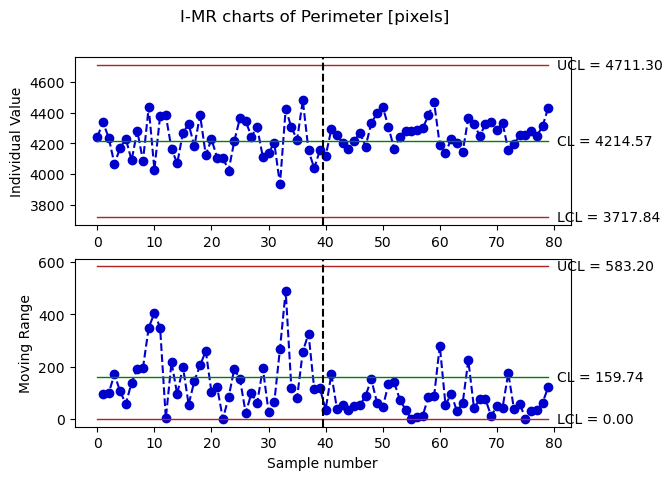

The index of the OOC point is: [] from Perimeter [pixels]


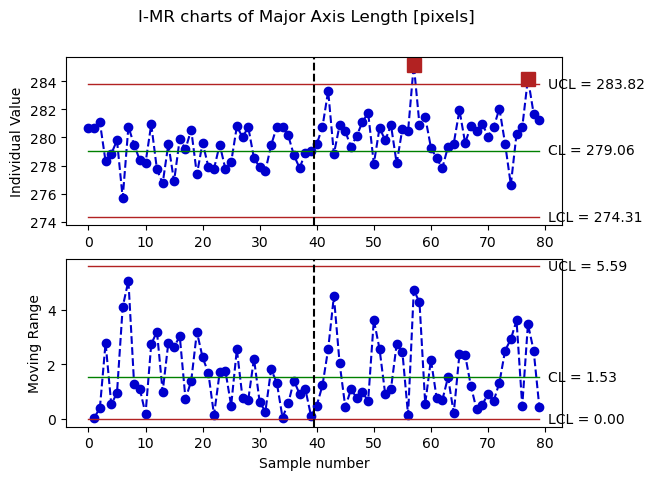

The index of the OOC point is: [57 77] from Major Axis Length [pixels]


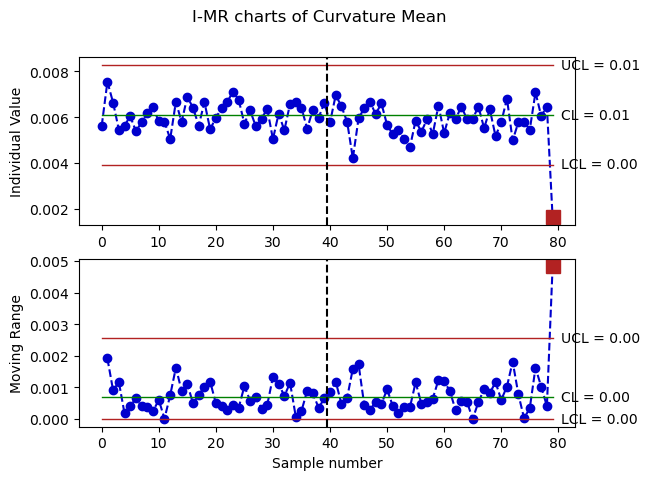

The index of the OOC point is: [79] from Curvature Mean


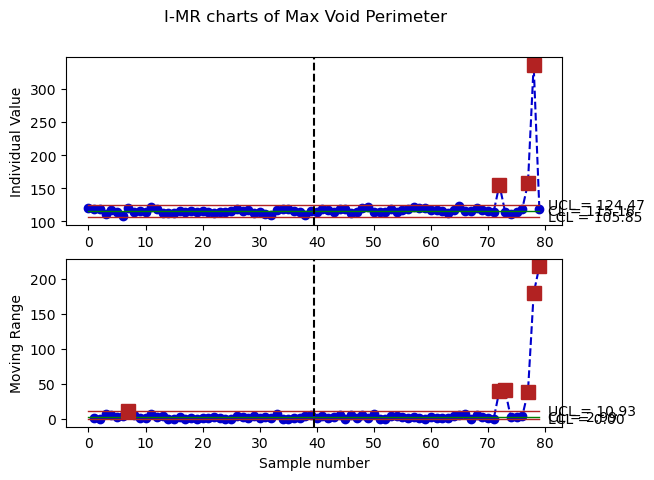

The index of the OOC point is: [72 77 78] from Max Void Perimeter


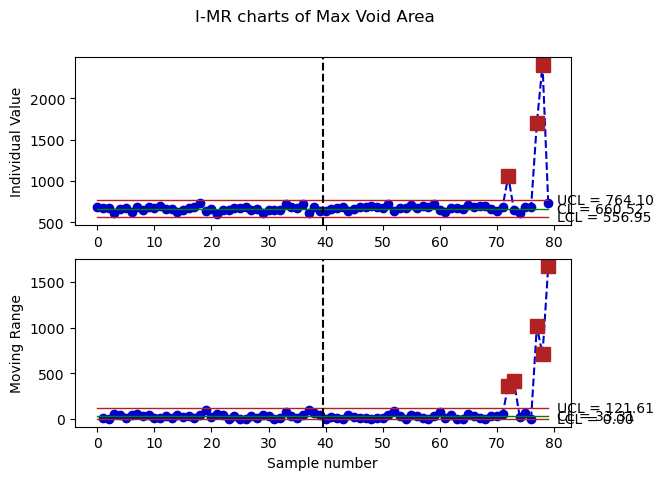

The index of the OOC point is: [72 77 78] from Max Void Area


In [186]:
ooc_idxs_set = set()

for chosvar in chosen_variables:
	# data=pd.DataFrame(df_shuffled[chosvar])
	data=pd.DataFrame(df_shuffled[chosvar])
	data_IMR = qda.ControlCharts.IMR(data,chosvar,K = K_alpha, 
								  subset_size=40,	
								  plotit=True)
								#   plotit=False)
	
	OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]
	print(f'The index of the OOC point is: {OOC_idx} from {chosvar}')
	ooc_idxs_set.update(OOC_idx)

{72, 77, 78, 79, 57}
height, width: 480 640
height, width: (228, 228)


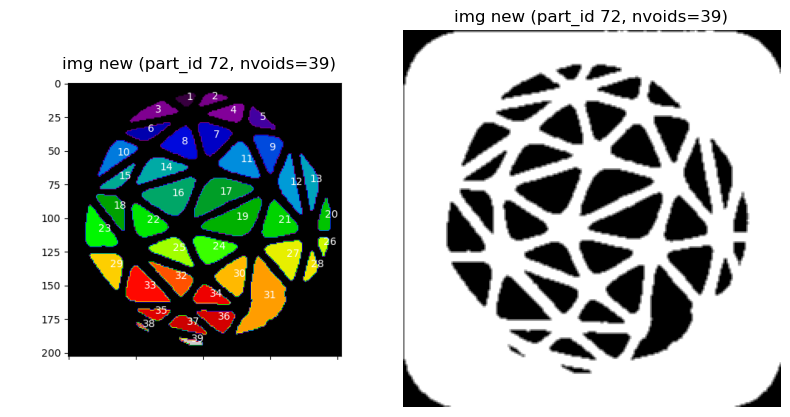

height, width: 480 640
height, width: (230, 230)


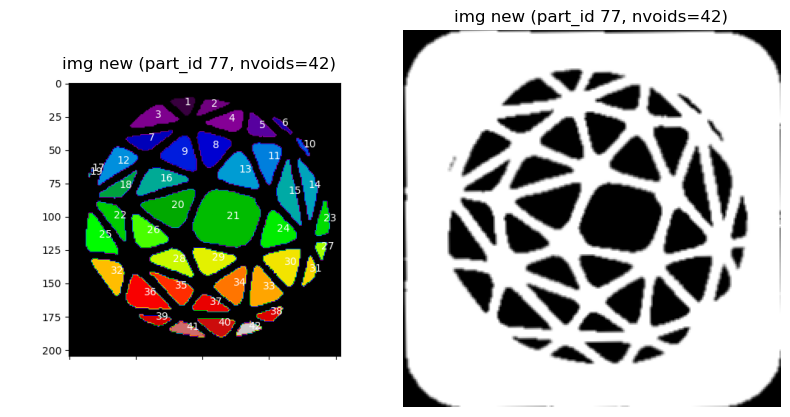

height, width: 480 640
height, width: (229, 228)


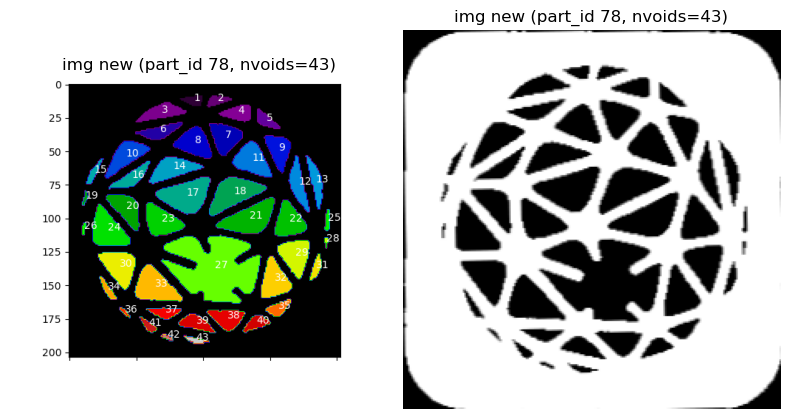

height, width: 480 640
height, width: (228, 230)


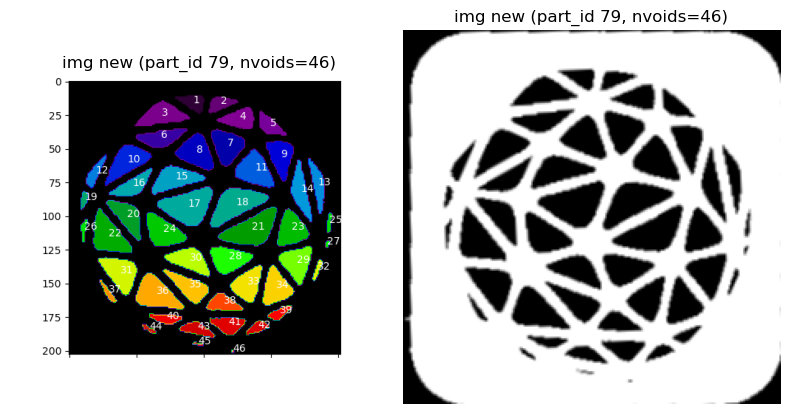

height, width: 480 640
height, width: (230, 230)


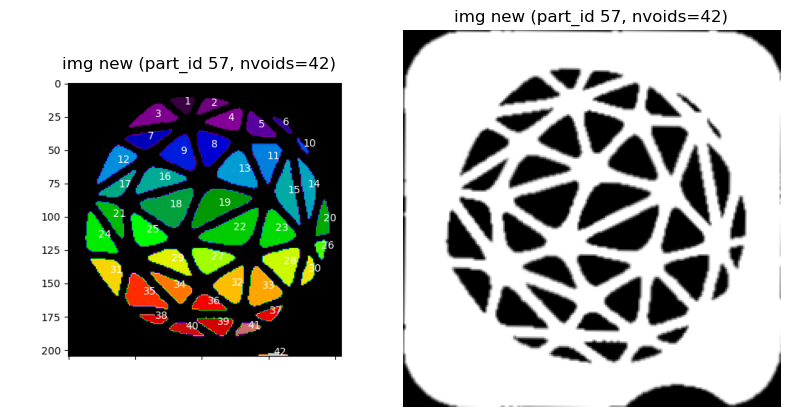

In [187]:
print(ooc_idxs_set)
for id in ooc_idxs_set:
	visualize_object(id)

Trying to reduce number of dimensions with PCA

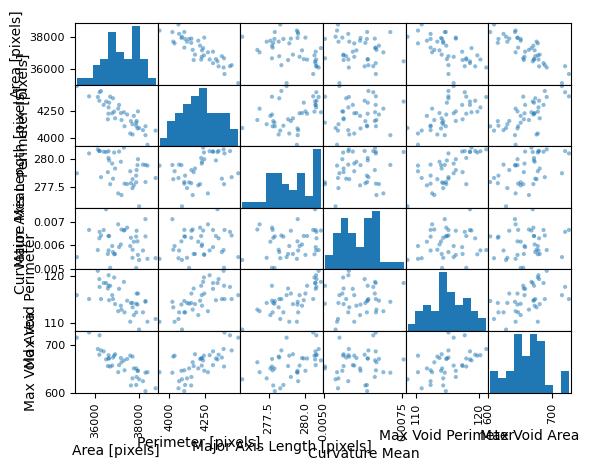

In [26]:
#Scatter plot
dataset=df_shuffled.copy()[chosen_variables]
pd.plotting.scatter_matrix(dataset)
plt.show()

# can see some linear correlated vars and some very sparse/uncorrelated

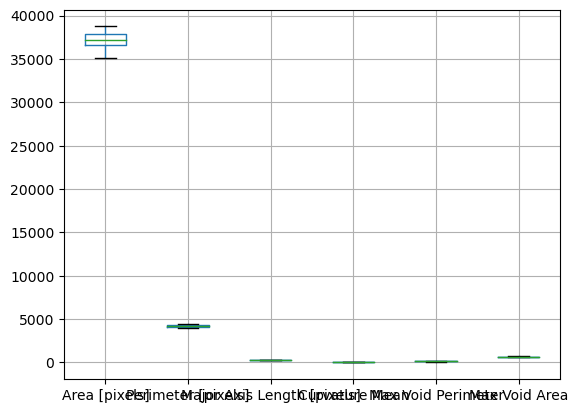

In [27]:
cov_matrix = dataset.cov()
#Boxplot
dataset.boxplot()
plt.show() 
# need to scale vars

In [28]:
# Standardize the data
data_std = (dataset - dataset.mean()) / dataset.std()
data_std.head(10)

Area [pixels]  Perimeter [pixels]  Major Axis Length [pixels]  \
0      -0.120400            0.696159                    1.220530   
1      -1.322847            1.263942                    1.369460   
2       0.015960           -0.389242                   -1.713320   
3      -2.509179            2.048206                   -0.241626   
4       0.847756           -0.795452                   -0.403028   
5       0.873789           -0.456789                   -0.028135   
6       1.947314           -1.149021                   -0.561496   
7       0.188270           -0.836215                   -0.944459   
8       0.550244           -0.468141                   -0.912912   
9      -0.854265            0.936632                    1.190450   

   Curvature Mean  Max Void Perimeter  Max Void Area  
0       -0.320603            0.734593      -0.087566  
1       -0.540733            2.033553       1.091536  
2        0.997786           -0.763215       0.120511  
3       -1.065561            0.278871       1.923843  
4        0.464373           -0.962063      -1.544103  
5        0.906485            0.395262      -0.954552  
6       -1.147576           -1.441878      -1.786859  
7        0.970252           -0.962063      -0.469040  
8        0.380388           -0.283401      -1.578783  
9        2.512814            1.156382       0.328588

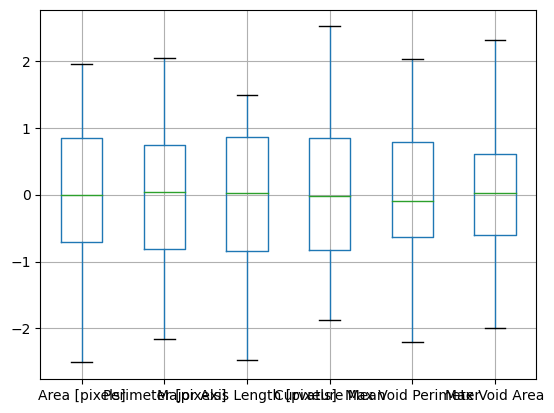

In [29]:
#cov matrix
cov_matrix_std = data_std.cov()
#Boxplot
data_std.boxplot()
plt.show() 

In [30]:
# Create the PCA object
pca = PCA()
# Fit the PCA object to the data
pca.fit(data_std)

#print("Eigenvalues \n", pca.explained_variance_)
#print("\nEigenvectors \n", pca.components_)
#print("\nExplained variance ratio \n", pca.explained_variance_ratio_)

print("\nCumulative explained variance ratio \n", np.cumsum(pca.explained_variance_ratio_))



Cumulative explained variance ratio 
 [0.58294624 0.7500854  0.88766952 0.96241784 0.98677031 1.        ]


In [31]:
# Compute the scores (i.e. all the principal components, n x 3) 
scores = pca.transform(data_std)
# create a dataframe with the scores
scores_df = pd.DataFrame(scores)
# Print the first rows of the scores dataframe
scores_df.head()

0         1         2         3         4         5
0 -1.070331  0.047652 -1.039671 -0.253587 -0.588052 -0.000944
1 -3.048679 -0.529948 -1.046559 -0.347395  0.224019  0.025203
2  0.969362  0.283944  1.796415 -0.055416  0.641769  0.132273
3 -2.949012 -2.266705  1.206828  0.210327 -0.119718 -0.338011
4  1.991591  0.775963  0.098128 -0.336768 -0.412846 -0.421063

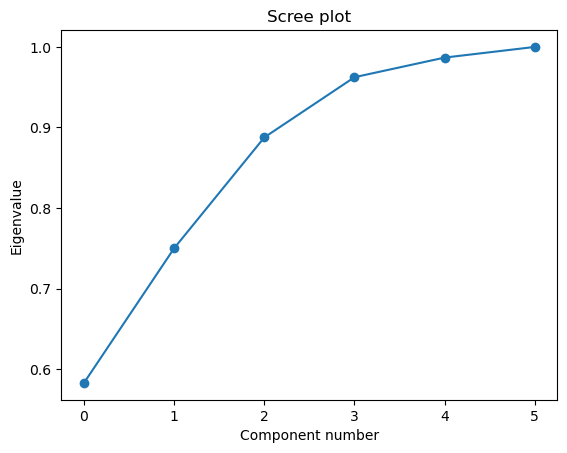

In [32]:
# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.title('Scree plot')
plt.show()

# keeping 4 pcs should be enough (more than 95% variability explained)

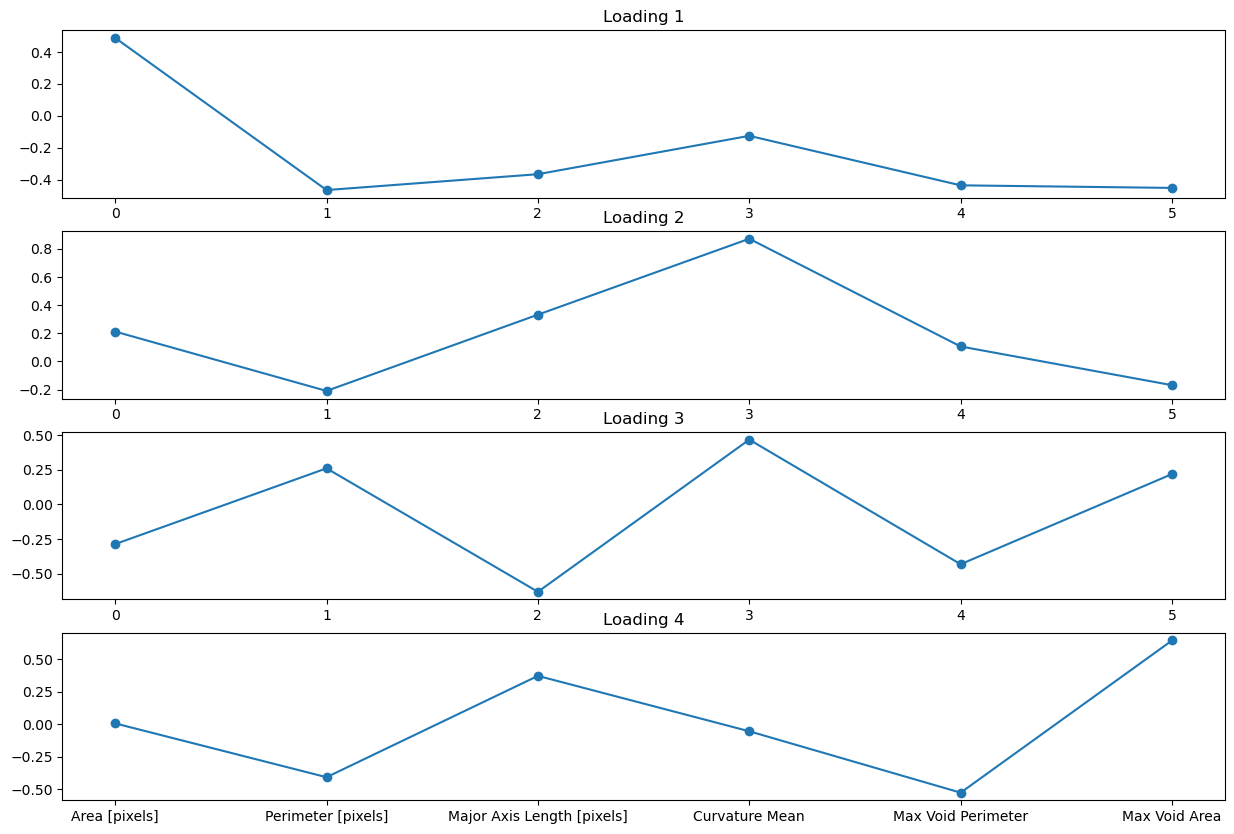

In [33]:
# Loadings
# Plot only the first k PCs
k = 4
fig, ax = plt.subplots(k,1, figsize = (15, 10))
for i in range(k):
   ax[i].plot(pca.components_[i], 'o-')
   ax[i].set_title('Loading ' + str(i+1))
   plt.xticks(ticks=np.arange(0, 6, step=1), labels=dataset.columns)


In [44]:
scores_df.columns=['A','B','C','D','E','F']
for col in scores_df.columns:
	summary_assumptions(scores_df.loc[:, col].values,col,0)
	print()

(A) Normality p-value = 0.203169047832489 - Normality at alpha 5%? True
(A) Runs test p-value = 1.0 - Random data at alpha 5%? True

(B) Normality p-value = 0.43061187863349915 - Normality at alpha 5%? True
(B) Runs test p-value = 0.20003686222311 - Random data at alpha 5%? True

(C) Normality p-value = 0.2675721049308777 - Normality at alpha 5%? True
(C) Runs test p-value = 0.6884997410966345 - Random data at alpha 5%? True

(D) Normality p-value = 0.09094800055027008 - Normality at alpha 5%? True
(D) Runs test p-value = 0.797379392453563 - Random data at alpha 5%? True

(E) Normality p-value = 0.819084644317627 - Normality at alpha 5%? True
(E) Runs test p-value = 0.3272754635466901 - Random data at alpha 5%? True

(F) Normality p-value = 0.9792324304580688 - Normality at alpha 5%? True
(F) Runs test p-value = 0.5217024890869293 - Random data at alpha 5%? True



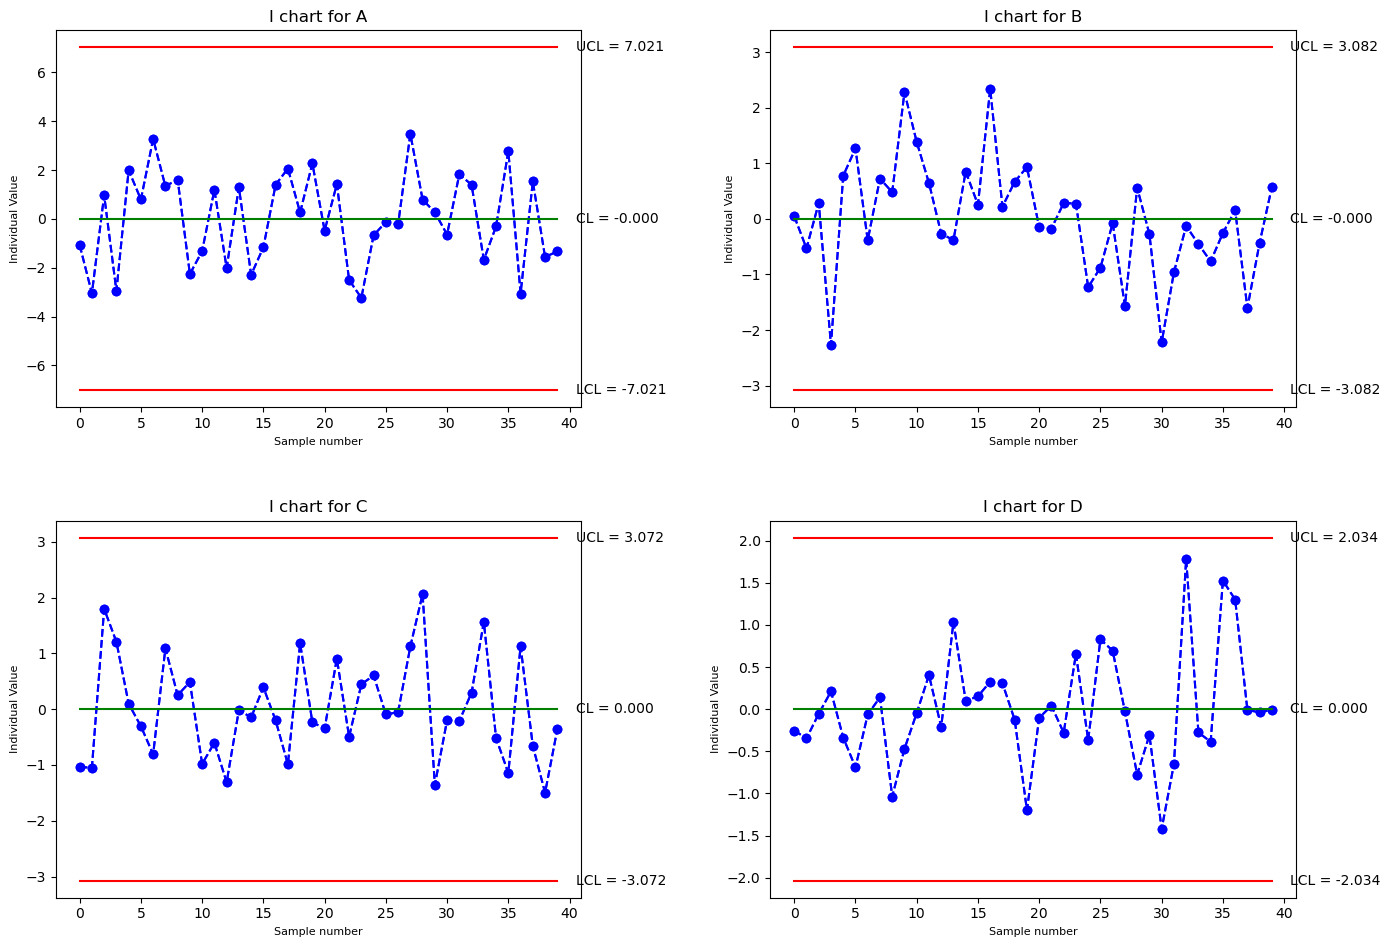

In [45]:
# with different alpha/k
n_var=4
alpha = 0.0027/n_var
K_alpha = stats.norm.ppf(1-alpha/2)

# manually and just the I one
d2 = 1.128
plt.figure(figsize=(16,24))
# plt.figure(figsize=(8.2, 11.69),dpi=100)
# add subplots structure
for i,chosvar in enumerate(['A','B','C','D'],start=1):
	df = pd.DataFrame(scores_df.loc[:,chosvar])
	df['MR'] = df[chosvar].diff().abs()
	df['I_UCL'] = df[chosvar].mean() + (K_alpha*df['MR'].mean()/d2)
	df['I_CL'] = df[chosvar].mean()
	df['I_LCL'] = df[chosvar].mean() - (K_alpha*df['MR'].mean()/d2)
	df['I_TEST1'] = np.where((df[chosvar] > df['I_UCL']) |
	(df[chosvar] < df['I_LCL']), df[chosvar], np.nan)
	# df.head()

	# Plot the I chart
	plt.subplot(4,2,i)
	plt.title(f'I chart for {chosvar}')
	plt.plot(df[chosvar], color='b', linestyle='--', marker='o')
	plt.plot(df[chosvar], color='b', linestyle='--', marker='o')
	plt.plot(df['I_UCL'], color='r')
	plt.plot(df['I_CL'], color='g')
	plt.plot(df['I_LCL'], color='r')
	plt.ylabel('Individual Value',fontsize=8)
	plt.xlabel('Sample number',fontsize=8)
	# add the values of the control limits on the right side of the plot
	plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.3f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
	plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.3f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
	plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.3f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
	# highlight the points that violate the alarm rules
	plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
	# plt.show()
plt.subplots_adjust(wspace=0.36) 
plt.subplots_adjust(hspace=0.3) 

# Multivariate CC

In [23]:
df_new_parts.head()

Image name      Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp      top_left        part   0          38291            4105.674   
1  img01.bmp   bottom_left        part   0          37887            4155.306   
2  img01.bmp     top_right        part   0          37334            4106.076   
3  img01.bmp  bottom_right        part   0          37868            4139.319   
4  img02.bmp      top_left        part   0          36599            4223.005   

   Eccentricity  Orientation [radians]  Solidity  Extent  \
0         0.153                 -1.268     0.760   0.743   
1         0.157                 -1.304     0.752   0.735   
2         0.189                  1.564     0.752   0.734   
3         0.164                 -1.070     0.756   0.738   
4         0.118                 -0.817     0.730   0.713   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0                     277.925                     274.667   
1                     279.026                     275.584   
2                     277.777                     272.791   
3                     277.900                     274.158   
4                     280.140                     278.182   

   Equivalent Diameter [pixels]  Part_ID  Num_voids  Curvature Mean  \
0                       220.802        0         41        0.006382   
1                       219.634        1         42        0.006624   
2                       218.026        2         46        0.006660   
3                       219.579        3         45        0.005039   
4                       215.869        4         41        0.006398   

   Max Void Perimeter  Max Void Area  
0             114.740          603.0  
1             116.326          633.0  
2             112.326          647.0  
3             114.154          651.0  
4             117.983          672.0

In [24]:
# data = df_shuffled[[
data = df_new_parts[[
'Area [pixels]',
'Perimeter [pixels]',
'Major Axis Length [pixels]',
'Curvature Mean',
'Max Void Perimeter',
'Max Void Area']]

# data_std = (data - data.mean()) / data.std()
# data = data_std
# standardizing does not change anything

In [27]:
from pingouin import multivariate_normality 
multivariate_normality(data, alpha=.05) 

# data are multinormal 
# Shuffled data are multinormal 


HZResults(hz=0.9134299020657731, pval=0.21279330314562311, normal=True)

In [25]:
alpha = 0.0027 # significance level
# alpha = 0.01 # significance level
n = 1          # sample size
m = len(data)  # number of samples
p = 6         # number of variables

In [19]:
np.outer([1, 2],[3, 4]) # example

array([[3, 4],
       [6, 8]])

In [26]:
###### long period
# Calcolo del vettore medio
Xbar = data.mean(axis=0)
print(Xbar)

# Inizializzazione della matrice di varianza S
S = np.zeros((data.shape[1], data.shape[1]))

# Calcolo della matrice di varianza S
for i in range(m):
    diff = data.iloc[i] - Xbar
    S += np.outer(diff, diff)
    # S += data.iloc[i]-Xbar.dot(data.iloc[i]-Xbar.transpose())

S /= (m - 1)

print("La matrice di varianza S è:")
print(S)

S1 = S
S1_inv = np.linalg.inv(S1)

Area [pixels]                 37182.125000
Perimeter [pixels]             4214.573575
Major Axis Length [pixels]      279.064350
Curvature Mean                    0.006108
Max Void Perimeter              115.161175
Max Void Area                   660.525000
dtype: float64
La matrice di varianza S è:
[[ 6.50745548e+05 -9.09027908e+04 -4.46412788e+02 -6.39222057e-02
  -1.48045333e+03 -1.94592981e+04]
 [-9.09027908e+04  1.68346372e+04  6.33472965e+01  9.46423915e-03
   2.46714568e+02  2.56581156e+03]
 [-4.46412788e+02  6.33472965e+01  1.85792069e+00  1.52526184e-04
   2.78543012e+00  1.93262987e+01]
 [-6.39222057e-02  9.46423915e-03  1.52526184e-04  3.23946753e-07
   2.24744723e-04  2.01646161e-03]
 [-1.48045333e+03  2.46714568e+02  2.78543012e+00  2.24744723e-04
   8.68464897e+00  4.01291365e+01]
 [-1.94592981e+04  2.56581156e+03  1.93262987e+01  2.01646161e-03
   4.01291365e+01  8.31486538e+02]]


29.958689896027398


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


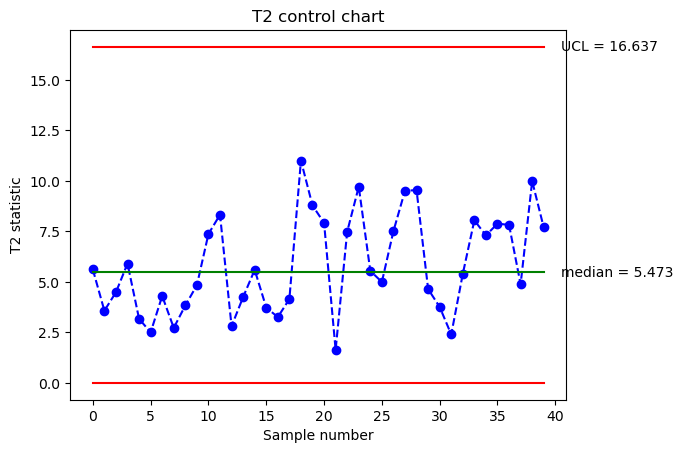

In [27]:
# Calculate the Hotelling T2 statistic
data_CC = data.copy()
data_CC['T2'] = np.nan
for i in range(m):
    data_CC['T2'].iloc[i] = n * (data.iloc[i] - Xbar).transpose().dot(S1_inv).dot(data.iloc[i] - Xbar)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['T2_UCL'] = ((m-1)**2)/m*stats.beta.ppf(1 - alpha, p/2, (m-p-1)/2) # stiamo stiamando i limiti con i dati --> siamo nella fase I
# data_CC['T2_UCL'] = stats.chi2.ppf(1 - alpha, p) 
# data_CC['T2_UCL'] = p*(m-1)/(m-p)*stats.f.ppf(1 - alpha, p, m-p) 

# what will be the phase 2 limit?
phase2_UCL = (p*(m-1)*(m+1))/(m*m-m*p)*stats.f.ppf(1 - alpha, p, m-p)
print(phase2_UCL)

data_CC['T2_CL'] = data_CC['T2'].median()
data_CC['T2_LCL'] = 0

# Add one column to test if the sample is out of control
data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)

# Plot the T2 control chart
plt.title('T2 control chart')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In [28]:
###### short period
# Create the V matrix
V = data.diff().dropna()

# Calculate the short range estimator S2
S2 = 1/2 * V.transpose().dot(V) / (m-1)
S2_inv = np.linalg.inv(S2)

# Display the short range estimator
print("The short range estimator is: \n", S2)

# Calculate the Xbar from the data
Xbar = data.mean()

The short range estimator is: 
                             Area [pixels]  Perimeter [pixels]  \
Area [pixels]               330261.076923       -34212.288897   
Perimeter [pixels]          -34212.288897         7159.094310   
Major Axis Length [pixels]    -211.841551           19.310658   
Curvature Mean                  -0.050519            0.003251   
Max Void Perimeter            -640.555218          101.526152   
Max Void Area                -9210.961538          858.679205   

                            Major Axis Length [pixels]  Curvature Mean  \
Area [pixels]                              -211.841551   -5.051857e-02   
Perimeter [pixels]                           19.310658    3.250789e-03   
Major Axis Length [pixels]                    1.813004    1.774686e-04   
Curvature Mean                                0.000177    2.995327e-07   
Max Void Perimeter                            2.586398    1.938340e-04   
Max Void Area                                15.049256    1.651945e-

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


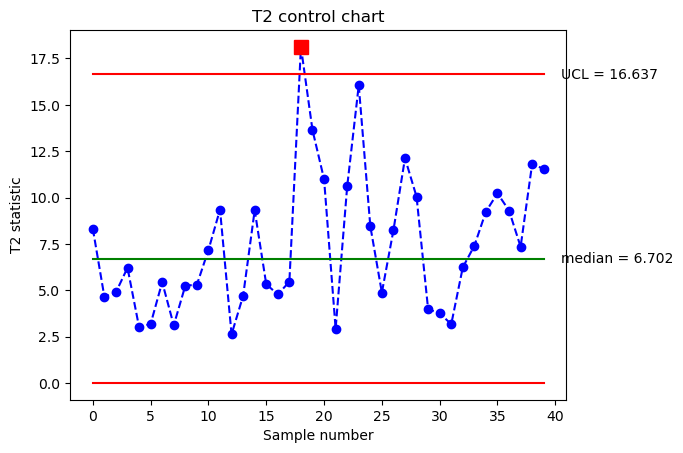

In [29]:
# Calculate the Hotelling T2 statistic
data_CC = data.copy()
data_CC['T2'] = np.nan
for i in range(m):
    data_CC['T2'].iloc[i] = n * (data.iloc[i] - Xbar).transpose().dot(S2_inv).dot(data.iloc[i] - Xbar)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['T2_UCL'] = ((m-1)**2)/m*stats.beta.ppf(1 - alpha, p/2, (m-p-1)/2) # stiamo stiamando i limiti con i dati --> siamo nella fase I
# data_CC['T2_UCL'] = p*(m-1)/(m-p)*stats.f.ppf(1 - alpha, p, m-p) 
data_CC['T2_CL'] = data_CC['T2'].median()
data_CC['T2_LCL'] = 0

# Add one column to test if the sample is out of control
data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)

# Plot the T2 control chart
plt.title('T2 control chart')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In [31]:
# No assignable cause --> final control charts

In [86]:
np.where(data_CC["T2_TEST"].notnull())[0]

array([18], dtype=int64)

height, width: 480 640
height, width: (226, 226)


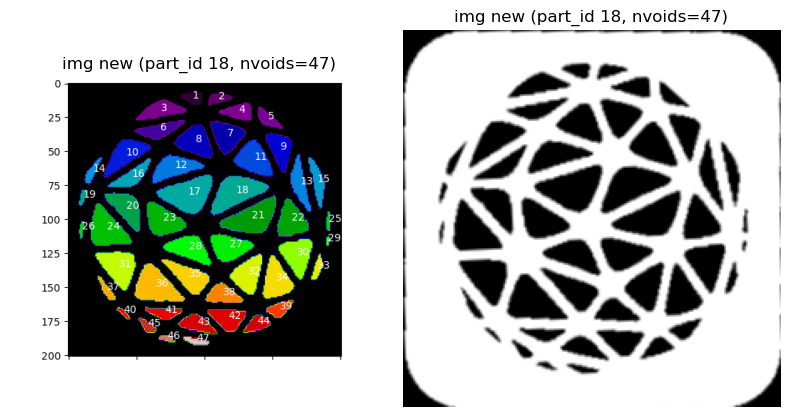

In [32]:
visualize_object(18) # very normal
# also ids 6 and 14 have 47 voids
# so nothing special really

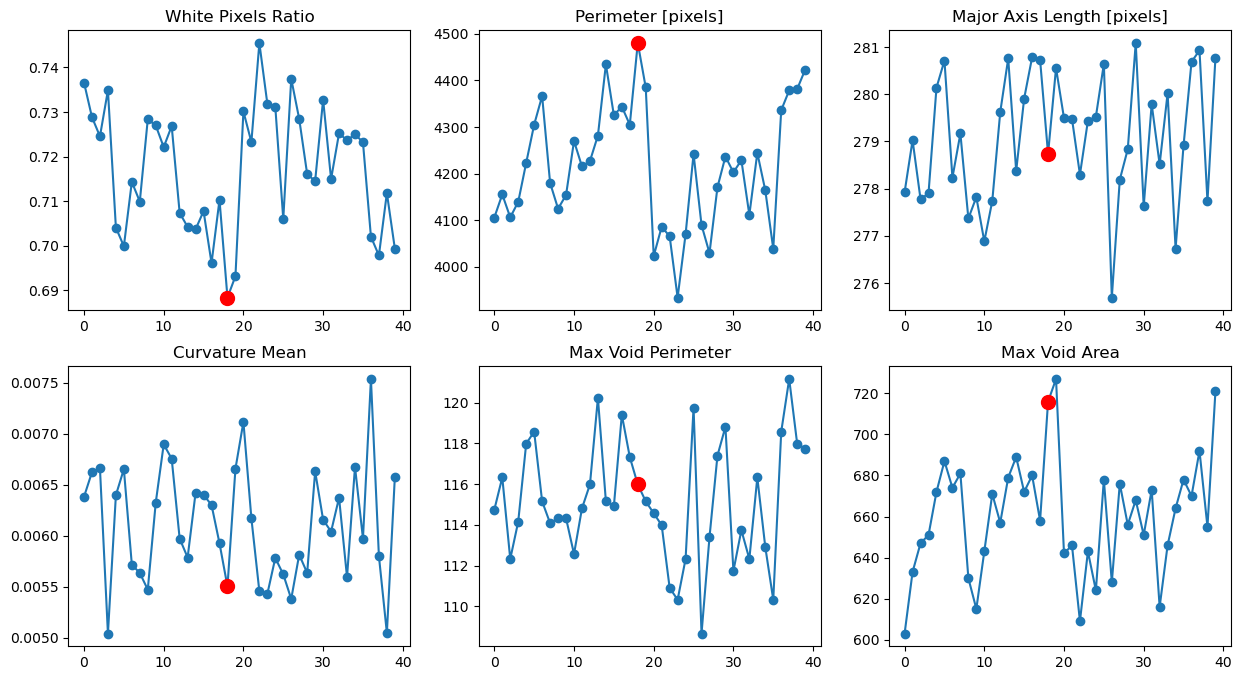

In [88]:
plt.figure(figsize=(15,8))
for idx,col in enumerate(data.columns,start=1):
	plt.subplot(2,3,idx)
	plt.plot(data[col],'o-')
	plt.plot(18, data[col].iloc[18], 'ro', markersize=10)
	plt.title(col)
	# plt.show()

Attempt using trays

In [ ]:
# Break single column data in different samples
m1=10   #number of trays
n1=4    #elements per tray
trays = {}

# Loop through each column name in the DataFrame
for col in chosen_variables:
    # Create a new DataFrame with a single column
    #trays[col] = data[[col]]
    trays[col]=pd.DataFrame(np.array(data[col]).reshape(m1,n1))

In [ ]:
for key, tray in trays.items():
    print(f"DataFrame for column {key}:")
    print(tray.head())
    print()

DataFrame for column Area [pixels]:
       0      1      2      3
0  38291  37887  37334  37868
1  36599  36382  36808  36903
2  37697  37626  37046  37454
3  36771  36607  36260  36630
4  36185  37085  35158  35716

DataFrame for column Perimeter [pixels]:
          0         1         2         3
0  4105.674  4155.306  4106.076  4139.319
1  4223.005  4305.088  4366.544  4180.034
2  4124.720  4153.833  4269.906  4215.355
3  4226.898  4281.740  4434.485  4325.414
4  4343.774  4304.899  4480.325  4384.828

DataFrame for column Major Axis Length [pixels]:
         0        1        2        3
0  277.925  279.026  277.777  277.900
1  280.140  280.715  278.233  279.169
2  277.368  277.820  276.883  277.739
3  279.623  280.759  278.375  279.910
4  280.785  280.728  278.735  280.557

DataFrame for column Curvature Mean:
          0         1         2         3
0  0.006382  0.006624  0.006660  0.005039
1  0.006398  0.006654  0.005715  0.005634
2  0.005471  0.006325  0.006896  0.006756
3  0.0

In [ ]:
#data_stack[['Area [pixels]', 'Perimeter [pixels]', 'Major Axis Length [pixels]','Curvature Mean','Max Void Perimeter','Max Void Area']] = Cov1.transpose().melt()

#new dataframe to store stacked data
data_stack = pd.DataFrame()
data_stack[['sample', 'Area [pixels]']] = trays['Area [pixels]'].transpose().melt()
data_stack['Perimeter [pixels]'] = trays['Perimeter [pixels]'].transpose().melt()['value']
data_stack['Major Axis Length [pixels]'] = trays['Major Axis Length [pixels]'].transpose().melt()['value']
data_stack['Curvature Mean'] = trays['Curvature Mean'].transpose().melt()['value']
data_stack['Max Void Perimeter'] = trays['Max Void Perimeter'].transpose().melt()['value']
data_stack['Max Void Area'] = trays['Max Void Area'].transpose().melt()['value']

data_stack.head(10)

sample  Area [pixels]  Perimeter [pixels]  Major Axis Length [pixels]  \
0       0          38291            4105.674                     277.925   
1       0          37887            4155.306                     279.026   
2       0          37334            4106.076                     277.777   
3       0          37868            4139.319                     277.900   
4       1          36599            4223.005                     280.140   
5       1          36382            4305.088                     280.715   
6       1          36808            4366.544                     278.233   
7       1          36903            4180.034                     279.169   
8       2          37697            4124.720                     277.368   
9       2          37626            4153.833                     277.820   

   Curvature Mean  Max Void Perimeter  Max Void Area  
0        0.006382             114.740          603.0  
1        0.006624             116.326          633.0  
2        0.006660             112.326          647.0  
3        0.005039             114.154          651.0  
4        0.006398             117.983          672.0  
5        0.006654             118.569          687.0  
6        0.005715             115.154          674.0  
7        0.005634             114.083          681.0  
8        0.005471             114.326          630.0  
9        0.006325             114.326          615.0

In [ ]:
#new dataframe to store sample mean
sample_mean = pd.DataFrame()

sample_mean['Area [pixels]'] = trays['Area [pixels]'].mean(axis=1)
sample_mean['Perimeter [pixels]'] = trays['Perimeter [pixels]'].mean(axis=1)
sample_mean['Major Axis Length [pixels]'] = trays['Major Axis Length [pixels]'].mean(axis=1)
sample_mean['Curvature Mean'] = trays['Curvature Mean'].mean(axis=1)
sample_mean['Max Void Perimeter'] = trays['Max Void Perimeter'].mean(axis=1)
sample_mean['Max Void Area'] = trays['Max Void Area'].mean(axis=1)

#Calculate grand mean
Xbarbar = sample_mean.mean()
print(Xbarbar)

Area [pixels]                 37182.125000
Perimeter [pixels]             4214.573575
Major Axis Length [pixels]      279.064350
Curvature Mean                    0.006108
Max Void Perimeter              115.161175
Max Void Area                   660.525000
dtype: float64


In [ ]:
# Compute variance and covariance matrix of each sample
cov_matrix = data_stack.groupby('sample').cov()

# Compute mean covariance matrix
S = cov_matrix.groupby(level=1).mean()
cols = S.columns.tolist()
S = S.reindex(columns=cols, index=cols)
S_inv = np.linalg.inv(S)

In [ ]:
p = 6          # number of random variables
m = 10          # number of samples
n = 4           # number of replicates (sample size)
alpha = 0.0027    # significance level

UCL = (p * (m-1) * (n-1)) / (m * (n-1) - (p-1)) * stats.f.ppf(1-alpha, p, m*n - m + 1 - p)

print('UCL = %.3f' % UCL)

UCL = 30.035


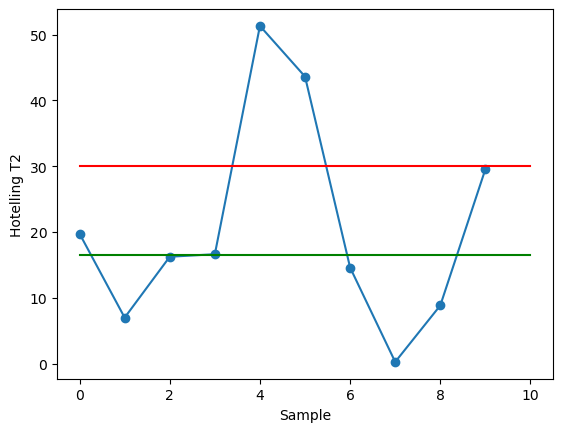

In [ ]:
# Calculate Hotelling T2 statistic for all samples
T2 = []
for i in range(m):
    T2.append(n * (sample_mean.iloc[i]-Xbarbar).transpose().dot(S_inv).dot(sample_mean.iloc[i]-Xbarbar))

# Plot Hotelling T2 statistic
plt.plot(T2, 'o-')
plt.plot([0, m], [UCL, UCL], 'r-')
plt.plot([0, m], [np.median(T2), np.median(T2)], 'g-')
plt.xlabel('Sample')
plt.ylabel('Hotelling T2')
plt.show()

# References/Bibliography

For our segmentation implementation
- https://gist.github.com/jdhao/1cb4c8f6561fbdb87859ac28a84b0201
- https://stackoverflow.com/questions/11627362/how-to-straighten-a-rotated-rectangle-area-of-an-image-using-opencv-in-python

For computing the curvature
- https://en.wikipedia.org/wiki/Curvature#In_terms_of_a_general_parametrization
